# Automatic Number Plate Recognition System

# 1. Dependencies

**Note**: Newer Python versions require users to install dependencies in a virtual environment. Learn how to create a virtual environment [here](https://docs.python.org/3/library/venv.html), or if using Visual Studio Code, [here](https://code.visualstudio.com/docs/python/environments).

In [134]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [135]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [136]:
!pip install ultralytics scikit-learn tqdm

In [137]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import torch
import xml.etree.ElementTree as xet
import cv2
import re
import os
from glob import glob

from sklearn.model_selection import train_test_split
import shutil

from tqdm import tqdm

Make sure CUDA is available. CUDA is a program created by Nvidia that gives PyTorch direct access to the GPU, making processing way more efficient. CUDA cores (or devices) are computer cores that are specialised for parallel computing. If there aren't any CUDA cores available, it's probably because you're running the notebook on a CPU, not a GPU. Google Colab offers


In [138]:
print(f'{torch.cuda.is_available() = }')
print(f'{torch.cuda.device_count() = }')

torch.cuda.is_available() = True
torch.cuda.device_count() = 1


# 2. Preprocessing

## 2.1 Define preprocessing

In [139]:
def preprocess_image(image):
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian Blur to reduce noise
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 1.4)

    # Apply Canny edge detection
    edges = cv2.Canny(blurred_image, threshold1=100, threshold2=200)

    return edges

In [140]:
def process_dataset(input_dir, output_dir):
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Get list of all image files
    image_files = [f for f in os.listdir(input_dir) if f.lower().endswith(('.png'))]

    # Process each image
    for filename in tqdm(image_files, desc="Processing images"):
        # Read the image
        image_path = os.path.join(input_dir, filename)
        image = cv2.imread(image_path)

        if image is None:
            print(f"Error reading image: {filename}")
            continue

        # Preprocess the image
        processed_image = preprocess_image(image)

        # Save the processed image
        output_path = os.path.join(output_dir, filename)
        cv2.imwrite(output_path, processed_image)

## 2.2 Preprocess images in dataset

In [141]:
dir = "drive/MyDrive/dataset"
input_directory = f"{dir}/images"
output_directory = "dataset/preprocessed_images"
dataset_path = "dataset"

In [142]:
process_dataset(input_directory, output_directory)

Processing images: 100%|██████████| 433/433 [00:19<00:00, 22.12it/s]


# 3. Data

## 3.1 Find data

In [143]:
# Copy over images
import shutil
try:
    shutil.copyfile(f"{dir}/datasets.yaml", f"{dataset_path}/datasets.yaml")
except FileNotFoundError:
    pass
try:
    shutil.copytree(f"{dir}/images", f"{dataset_path}/images")
except FileExistsError:
    pass
try:
    shutil.copytree(f"{dir}/preprocessed_images", f"{dataset_path}/preprocessed_images")
except FileExistsError:
    pass
try:
    shutil.copytree(f"{dir}/annotations", f"{dataset_path}/annotations")
except FileExistsError:
    pass

In [144]:
def extract_number_from_str(filename):
    """Function to find a given image or label number to adjoin images and labels together."""
    match = re.search(r'(\d+)', filename)

    if match:
        return int(match.group(0))
    else:
        return 0

In [145]:
# Store labels and image info
labels_dict = dict(
    img_path=[],
    xmin=[],
    xmax=[],
    ymin=[],
    ymax=[],
    img_w=[],
    img_h=[]
)

In [146]:
# get XML files from the annotations dir
xml_files = glob(f'{dataset_path}/annotations/*.xml')
assert xml_files, "Couldn't find dataset. Make sure to upload the dataset to Colab."

In [147]:
# Process each XML file, sorted by the numerical value in the filename
for filename in sorted(xml_files, key=extract_number_from_str):

    info = xet.parse(filename)
    root = info.getroot()

    # Extract bounding box coordinates
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    # join full path
    img_name = root.find('filename').text
    img_path = os.path.join(dataset_path, 'preprocessed_images', img_name)

    # add to dictionary
    labels_dict['img_path'].append(img_path)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

    # Read img and get dimensions
    height, width, _ = cv2.imread(img_path).shape
    labels_dict['img_w'].append(width)
    labels_dict['img_h'].append(height)

    alldata = pd.DataFrame(labels_dict)

alldata

,img_path,xmin,xmax,ymin,ymax,img_w,img_h
0,dataset/preprocessed_images/Cars0.png,226,419,125,173,500,268
1,dataset/preprocessed_images/Cars1.png,134,262,128,160,400,248
2,dataset/preprocessed_images/Cars2.png,229,270,176,193,400,400
3,dataset/preprocessed_images/Cars3.png,142,261,128,157,400,225
4,dataset/preprocessed_images/Cars4.png,156,503,82,253,590,350
...,...,...,...,...,...,...,...
428,dataset/preprocessed_images/Cars428.png,142,258,128,157,400,225
429,dataset/preprocessed_images/Cars429.png,86,208,166,195,301,400
430,dataset/preprocessed_images/Cars430.png,38,116,159,197,400,225
431,dataset/preprocessed_images/Cars431.png,55,343,82,147,400,192


## 3.2 Split data

In [148]:
# Split dataset for training, testing and validation
train, test = train_test_split(alldata, test_size=1/10, random_state=42)
train, val = train_test_split(train, train_size=8/9, random_state=42)

print(f'''
Number of images in each set
Training:   {len(train)} images
Validation:  {len(val)} images
Testing:     {len(test)} images
''')


Number of images in each set
Training:   345 images
Validation:  44 images
Testing:     44 images



## 3.3 Convert data to YOLO format

In [149]:
def make_split_folder_in_yolo_format(split_name, split_df):
    # folders in YOLO format
    labels_path = os.path.join('datasets', 'cars_license_plates', split_name, 'labels')
    images_path = os.path.join('datasets', 'cars_license_plates', split_name, 'images')

    if not os.path.exists(labels_path):
        os.makedirs(labels_path)
        os.makedirs(images_path)

    for _, row in split_df.iterrows():
        img_name, img_extension = os.path.splitext(os.path.basename(row['img_path']))

        x_center = (row['xmin'] + row['xmax']) / 2 / row['img_w']
        y_center = (row['ymin'] + row['ymax']) / 2 / row['img_h']
        width = (row['xmax'] - row['xmin']) / row['img_w']
        height = (row['ymax'] - row['ymin']) / row['img_h']

        # save lables in YOLO format
        label_path = os.path.join(labels_path, f'{img_name}.txt')
        with open(label_path, 'w') as file:
            file.write(f"0 {x_center:.4f} {y_center:.4f} {width:.4f} {height:.4f}\n")


        shutil.copy(row['img_path'], os.path.join(images_path, img_name + img_extension))

    print(f"Created '{images_path}' and '{labels_path}'")

In [150]:
make_split_folder_in_yolo_format("train", train)
make_split_folder_in_yolo_format("val", val)
make_split_folder_in_yolo_format("test", test)

Created 'datasets/cars_license_plates/train/images' and 'datasets/cars_license_plates/train/labels'
Created 'datasets/cars_license_plates/val/images' and 'datasets/cars_license_plates/val/labels'
Created 'datasets/cars_license_plates/test/images' and 'datasets/cars_license_plates/test/labels'


# Object detection and bounding box

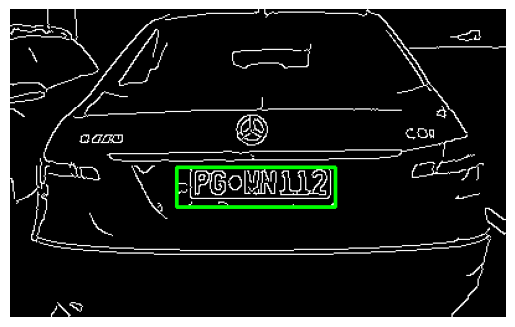

In [151]:
image_dir = 'datasets/cars_license_plates/train/images'
label_dir = 'datasets/cars_license_plates/train/labels'

image_files = sorted(os.listdir(image_dir))
first_image_file = image_files[0]

# Construct paths for image and its label
image_path = os.path.join(image_dir, first_image_file)
label_path = os.path.join(label_dir, os.path.splitext(first_image_file)[0] + '.txt')

image = cv2.imread(image_path)

# Convert img BGR to OpenCV
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


with open(label_path, 'r') as f:
    lines = f.readlines()


for line in lines:

    class_id, x_center, y_center, width, height = map(float, line.strip().split())
    img_height, img_width, _ = image.shape

    # Convert YOLO format to bounding box format
    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height

    x1 = int(x_center - width / 2)
    y1 = int(y_center - height / 2)
    x2 = int(x_center + width / 2)
    y2 = int(y_center + height / 2)

    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)


plt.imshow(image)
plt.axis('off')
plt.show()

In [152]:
datasets_yaml = '''
path: cars_license_plates

train: train/images
val: val/images
test: test/images

# number of classes
nc: 1

# class names
names: ['license_plate']
'''

# Write the content to the datasets.yaml file
with open('dataset/datasets.yaml', 'w') as file:
    file.write(datasets_yaml)

# Using YOLOv8 nano model

In [153]:
# using YOLOv8 nano
from ultralytics import YOLO
model = YOLO('yolov8n.pt')

In [154]:
os.environ['WANDB_MODE'] = 'offline'

In [155]:
def train_with_preprocessing(model, train_data):
    def preprocessed_dataset(data):
        for batch in data:
            yield [preprocess_image(img) for img in batch]

    results = model.train(data=preprocessed_dataset(train_data), epochs=100, imgsz=640)

In [156]:
model.train(
    data=f'{dataset_path}/datasets.yaml',
    epochs=100,
    batch=16,
    device='cuda',
    imgsz=320,  # Image size (width and height) for training
    cache=True
)

Ultralytics 8.3.24 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=dataset/datasets.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=True, device=cuda, workers=8, project=None, name=train15, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=Tr

train: Scanning /content/datasets/cars_license_plates/train/labels... 345 images, 0 backgrounds, 0 corrupt: 100%|██████████| 345/345 [00:00<00:00, 855.17it/s]


train: New cache created: /content/datasets/cars_license_plates/train/labels.cache
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.1GB RAM): 100%|██████████| 345/345 [00:01<00:00, 229.88it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/datasets/cars_license_plates/val/labels... 44 images, 0 backgrounds, 0 corrupt: 100%|██████████| 44/44 [00:00<00:00, 464.38it/s]

val: New cache created: /content/datasets/cars_license_plates/val/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.0GB RAM): 100%|██████████| 44/44 [00:00<00:00, 236.61it/s]


Plotting labels to runs/detect/train15/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 320 train, 320 val
Using 2 dataloader workers
Logging results to runs/detect/train15
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100     0.845G      2.094      3.176      1.488         19        320: 100%|██████████| 22/22 [00:04<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.11it/s]

                   all         44         44     0.0037      0.818      0.072     0.0368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100     0.833G      1.777      1.946      1.254         19        320: 100%|██████████| 22/22 [00:02<00:00,  8.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.26it/s]


                   all         44         44    0.00482      0.841     0.0274     0.0117

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100     0.843G       1.77      1.694      1.306         23        320: 100%|██████████| 22/22 [00:05<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.14it/s]

                   all         44         44          1      0.183      0.329      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100     0.835G      1.806      1.638      1.387         16        320: 100%|██████████| 22/22 [00:06<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.76it/s]

                   all         44         44      0.371      0.318      0.313       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100     0.835G      1.745      1.568      1.323         20        320: 100%|██████████| 22/22 [00:05<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.56it/s]

                   all         44         44      0.222      0.273      0.176     0.0562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100     0.841G      1.803       1.56      1.345         19        320: 100%|██████████| 22/22 [00:04<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.86it/s]

                   all         44         44      0.397      0.295      0.313       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100     0.835G      1.772      1.509      1.333         18        320: 100%|██████████| 22/22 [00:02<00:00,  8.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.74it/s]

                   all         44         44      0.568      0.227       0.31      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100     0.843G      1.803      1.496      1.309         19        320: 100%|██████████| 22/22 [00:02<00:00,  8.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.13it/s]

                   all         44         44      0.426      0.388      0.362      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100     0.835G      1.689      1.369        1.3         17        320: 100%|██████████| 22/22 [00:02<00:00,  8.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.69it/s]

                   all         44         44      0.573      0.659      0.617      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100     0.841G      1.714      1.346      1.303         18        320: 100%|██████████| 22/22 [00:04<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.05it/s]

                   all         44         44      0.677      0.432       0.51      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100     0.835G      1.608       1.25       1.25         19        320: 100%|██████████| 22/22 [00:03<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.57it/s]

                   all         44         44      0.821      0.312      0.446      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100     0.841G      1.646      1.252      1.285         21        320: 100%|██████████| 22/22 [00:02<00:00,  8.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.77it/s]

                   all         44         44      0.573      0.641      0.594      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100     0.835G      1.629      1.229      1.241         15        320: 100%|██████████| 22/22 [00:02<00:00,  8.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.84it/s]

                   all         44         44      0.717      0.636      0.714      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100     0.841G      1.642      1.247      1.271         16        320: 100%|██████████| 22/22 [00:03<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.49it/s]

                   all         44         44      0.882      0.568      0.716      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100     0.835G      1.567      1.167      1.203         19        320: 100%|██████████| 22/22 [00:04<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.27it/s]

                   all         44         44      0.744      0.636      0.737      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100     0.841G      1.531      1.135      1.208         13        320: 100%|██████████| 22/22 [00:02<00:00,  8.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.84it/s]

                   all         44         44       0.83      0.778      0.856      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100     0.835G      1.474      1.078      1.179         16        320: 100%|██████████| 22/22 [00:02<00:00,  8.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.48it/s]

                   all         44         44      0.757      0.659      0.704      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100     0.841G       1.47      1.017      1.182         21        320: 100%|██████████| 22/22 [00:02<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.70it/s]

                   all         44         44      0.762        0.5      0.662      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100     0.835G      1.486      1.006      1.201         17        320: 100%|██████████| 22/22 [00:05<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.45it/s]

                   all         44         44      0.782      0.817      0.816       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100     0.841G      1.495      1.008       1.19         24        320: 100%|██████████| 22/22 [00:03<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.22it/s]

                   all         44         44      0.789       0.85      0.853        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100     0.835G      1.418      0.991      1.155         21        320: 100%|██████████| 22/22 [00:03<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.21it/s]

                   all         44         44      0.924      0.833      0.872      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100     0.841G      1.441      1.024      1.174         14        320: 100%|██████████| 22/22 [00:03<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.12it/s]

                   all         44         44       0.83      0.818      0.834      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100     0.835G      1.448      1.011      1.164         14        320: 100%|██████████| 22/22 [00:04<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.15it/s]


                   all         44         44      0.946      0.705      0.861      0.392

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100     0.841G      1.413      0.958      1.175         15        320: 100%|██████████| 22/22 [00:02<00:00,  8.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.79it/s]

                   all         44         44      0.716      0.705      0.747      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100     0.835G      1.409     0.9357      1.158         22        320: 100%|██████████| 22/22 [00:02<00:00,  8.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.09it/s]


                   all         44         44      0.798      0.539       0.68      0.338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100     0.839G      1.423     0.9439      1.148         13        320: 100%|██████████| 22/22 [00:03<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.08it/s]

                   all         44         44      0.786      0.614      0.658      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100     0.835G      1.371     0.9191      1.138         18        320: 100%|██████████| 22/22 [00:04<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.63it/s]

                   all         44         44      0.736      0.571      0.666      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100     0.841G      1.359     0.8818      1.107         18        320: 100%|██████████| 22/22 [00:02<00:00,  8.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.90it/s]

                   all         44         44      0.875      0.773      0.833      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100     0.835G      1.349     0.9108      1.138         23        320: 100%|██████████| 22/22 [00:02<00:00,  8.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.22it/s]


                   all         44         44       0.88      0.832       0.85      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100     0.841G      1.361     0.8741      1.141         17        320: 100%|██████████| 22/22 [00:02<00:00,  8.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.30it/s]

                   all         44         44      0.864      0.795      0.833      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100     0.835G      1.336     0.8485      1.141         16        320: 100%|██████████| 22/22 [00:04<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.67it/s]

                   all         44         44      0.924      0.795      0.871      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100     0.841G      1.345     0.8653      1.143         17        320: 100%|██████████| 22/22 [00:03<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.08it/s]

                   all         44         44      0.872      0.776      0.809      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100     0.835G      1.395     0.8769       1.16         19        320: 100%|██████████| 22/22 [00:02<00:00,  8.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.30it/s]

                   all         44         44      0.861      0.845      0.867      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100     0.841G      1.282     0.8298      1.113         18        320: 100%|██████████| 22/22 [00:02<00:00,  7.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.37it/s]

                   all         44         44        0.9      0.817      0.844      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100     0.835G      1.296     0.8147      1.111         16        320: 100%|██████████| 22/22 [00:03<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.39it/s]

                   all         44         44      0.861      0.636      0.757      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100     0.841G        1.3     0.8511        1.1         19        320: 100%|██████████| 22/22 [00:03<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.90it/s]

                   all         44         44      0.916      0.739      0.821      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100     0.835G      1.331     0.8432      1.119         15        320: 100%|██████████| 22/22 [00:02<00:00,  8.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.41it/s]

                   all         44         44       0.88      0.818      0.877      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100     0.841G      1.291     0.8498      1.091         19        320: 100%|██████████| 22/22 [00:02<00:00,  7.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.02it/s]

                   all         44         44      0.826      0.865      0.856      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100     0.835G      1.284      0.839      1.095         20        320: 100%|██████████| 22/22 [00:03<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.66it/s]

                   all         44         44      0.857      0.682      0.808      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100     0.841G      1.275     0.7772      1.083         19        320: 100%|██████████| 22/22 [00:04<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.18it/s]

                   all         44         44      0.902      0.773      0.876      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100     0.835G      1.254     0.8201      1.088         17        320: 100%|██████████| 22/22 [00:02<00:00,  7.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.34it/s]

                   all         44         44      0.853      0.794      0.859      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100     0.841G      1.192     0.7667      1.078         17        320: 100%|██████████| 22/22 [00:02<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.56it/s]

                   all         44         44       0.88      0.837      0.862      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100     0.835G      1.233     0.7668      1.074         14        320: 100%|██████████| 22/22 [00:02<00:00,  8.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.24it/s]


                   all         44         44      0.958      0.795      0.895      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100     0.841G      1.273     0.7755       1.06         13        320: 100%|██████████| 22/22 [00:04<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.26it/s]

                   all         44         44      0.964      0.795      0.877      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100     0.835G      1.194     0.7406      1.043         16        320: 100%|██████████| 22/22 [00:03<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.73it/s]

                   all         44         44      0.963      0.818        0.9      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100     0.841G      1.184      0.745      1.068         18        320: 100%|██████████| 22/22 [00:02<00:00,  8.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.21it/s]

                   all         44         44      0.885      0.871      0.898      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100     0.835G      1.231     0.7431      1.072         17        320: 100%|██████████| 22/22 [00:02<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.50it/s]

                   all         44         44      0.878      0.818      0.868      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100     0.841G      1.195     0.7441      1.049         13        320: 100%|██████████| 22/22 [00:03<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.75it/s]

                   all         44         44      0.931      0.818      0.862      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100     0.835G      1.145     0.6951      1.034         12        320: 100%|██████████| 22/22 [00:04<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.90it/s]

                   all         44         44      0.897      0.864      0.881      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100     0.841G      1.196     0.7199       1.04         15        320: 100%|██████████| 22/22 [00:02<00:00,  8.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.05it/s]

                   all         44         44      0.933      0.841      0.881      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100     0.835G      1.154     0.7418      1.051         18        320: 100%|██████████| 22/22 [00:02<00:00,  8.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.66it/s]

                   all         44         44      0.831      0.818      0.866      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100     0.841G      1.135     0.7159      1.042         17        320: 100%|██████████| 22/22 [00:02<00:00,  7.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.54it/s]

                   all         44         44      0.844      0.886      0.887      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100     0.835G      1.171     0.7071      1.048         14        320: 100%|██████████| 22/22 [00:04<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.03it/s]

                   all         44         44      0.926      0.853      0.895      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100     0.841G      1.112     0.6821      1.034         23        320: 100%|██████████| 22/22 [00:02<00:00,  7.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.16it/s]


                   all         44         44      0.859      0.795      0.847      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100     0.833G       1.13     0.7207      1.042         10        320: 100%|██████████| 22/22 [00:02<00:00,  8.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.88it/s]

                   all         44         44      0.946      0.864      0.896      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100     0.843G      1.136        0.7      1.024         17        320: 100%|██████████| 22/22 [00:02<00:00,  8.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.70it/s]

                   all         44         44      0.915      0.795      0.849      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100     0.835G      1.098     0.6826      1.022         14        320: 100%|██████████| 22/22 [00:04<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.50it/s]

                   all         44         44      0.846      0.841      0.875      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100     0.841G      1.139     0.7067      1.026         19        320: 100%|██████████| 22/22 [00:03<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.46it/s]

                   all         44         44      0.806      0.864      0.858      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100     0.835G      1.106      0.668      1.019         15        320: 100%|██████████| 22/22 [00:02<00:00,  8.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.10it/s]

                   all         44         44      0.915      0.841      0.864      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100     0.841G      1.093     0.6754      1.042         17        320: 100%|██████████| 22/22 [00:02<00:00,  8.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.48it/s]

                   all         44         44      0.923      0.864      0.895      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100     0.835G      1.134     0.6692      1.044         19        320: 100%|██████████| 22/22 [00:03<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.12it/s]

                   all         44         44      0.902       0.84      0.862      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100     0.841G      1.067     0.6641      1.018         20        320: 100%|██████████| 22/22 [00:04<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.70it/s]

                   all         44         44      0.947      0.812      0.885       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100     0.833G      1.066     0.6544       1.03          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.84it/s]

                   all         44         44      0.972      0.788      0.883      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100     0.841G      1.079     0.6585      1.031         15        320: 100%|██████████| 22/22 [00:02<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.93it/s]

                   all         44         44      0.835      0.864      0.899      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100     0.835G      1.079     0.6515      1.013         16        320: 100%|██████████| 22/22 [00:02<00:00,  8.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.02it/s]

                   all         44         44      0.929      0.773      0.889      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100     0.841G      1.029     0.6319     0.9992         17        320: 100%|██████████| 22/22 [00:04<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.56it/s]

                   all         44         44       0.82      0.864      0.877      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100     0.835G       1.05      0.646      0.999         11        320: 100%|██████████| 22/22 [00:03<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.33it/s]


                   all         44         44      0.829      0.818      0.873      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100     0.841G      1.044     0.6267      0.985         21        320: 100%|██████████| 22/22 [00:02<00:00,  8.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.87it/s]

                   all         44         44      0.921       0.79      0.871      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100     0.835G      1.017     0.6231      1.005         17        320: 100%|██████████| 22/22 [00:02<00:00,  8.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.98it/s]

                   all         44         44      0.788      0.846      0.843      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100     0.841G      0.998     0.5965     0.9903         16        320: 100%|██████████| 22/22 [00:03<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.71it/s]

                   all         44         44      0.867      0.864      0.875      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100     0.835G      1.011     0.6184     0.9827         17        320: 100%|██████████| 22/22 [00:04<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.56it/s]

                   all         44         44      0.924      0.841       0.91      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100     0.841G     0.9662     0.5989     0.9858         15        320: 100%|██████████| 22/22 [00:02<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.68it/s]

                   all         44         44       0.95      0.862        0.9      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100     0.835G      1.026     0.6215     0.9833         16        320: 100%|██████████| 22/22 [00:02<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.36it/s]

                   all         44         44      0.944      0.841      0.885      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100     0.841G      1.053     0.6283     0.9979         16        320: 100%|██████████| 22/22 [00:02<00:00,  8.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.18it/s]

                   all         44         44      0.949      0.886      0.887      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100     0.835G     0.9974     0.6124     0.9991         11        320: 100%|██████████| 22/22 [00:04<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.25it/s]

                   all         44         44      0.927      0.862      0.901      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100     0.841G     0.9575     0.6127     0.9865         16        320: 100%|██████████| 22/22 [00:03<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.48it/s]

                   all         44         44      0.887      0.891      0.898      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100     0.835G     0.9662     0.5766     0.9799         17        320: 100%|██████████| 22/22 [00:02<00:00,  8.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.85it/s]

                   all         44         44      0.856      0.909      0.892      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100     0.841G     0.9628     0.5936     0.9747         14        320: 100%|██████████| 22/22 [00:02<00:00,  8.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.12it/s]

                   all         44         44      0.861      0.909      0.896      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100     0.835G     0.9958     0.5921      0.986         20        320: 100%|██████████| 22/22 [00:03<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.45it/s]

                   all         44         44      0.882      0.886      0.898      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100     0.841G     0.9735     0.5889     0.9864         20        320: 100%|██████████| 22/22 [00:04<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.14it/s]


                   all         44         44      0.947      0.818      0.885      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100     0.835G     0.9339     0.5745     0.9689         17        320: 100%|██████████| 22/22 [00:02<00:00,  8.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.82it/s]


                   all         44         44      0.901      0.818      0.885      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100     0.841G     0.9733     0.5856     0.9762         20        320: 100%|██████████| 22/22 [00:02<00:00,  8.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.75it/s]

                   all         44         44      0.864      0.866       0.91       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100     0.835G     0.9174     0.5576     0.9647         19        320: 100%|██████████| 22/22 [00:03<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.45it/s]

                   all         44         44      0.948      0.831      0.881      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100     0.841G     0.9069     0.5667     0.9543         20        320: 100%|██████████| 22/22 [00:04<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.26it/s]

                   all         44         44      0.906      0.878      0.892      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100     0.835G     0.9449      0.581     0.9674         16        320: 100%|██████████| 22/22 [00:02<00:00,  8.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.90it/s]

                   all         44         44      0.896      0.886      0.903      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100     0.841G     0.8962     0.5724     0.9637         15        320: 100%|██████████| 22/22 [00:02<00:00,  8.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.63it/s]

                   all         44         44      0.927      0.863      0.901      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100     0.835G     0.9166     0.5755     0.9587         22        320: 100%|██████████| 22/22 [00:02<00:00,  7.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.05it/s]

                   all         44         44       0.95      0.862        0.9      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100     0.841G     0.8958     0.5664     0.9648         14        320: 100%|██████████| 22/22 [00:04<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.32it/s]

                   all         44         44      0.907      0.883      0.898      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100     0.835G     0.8946       0.57     0.9617         21        320: 100%|██████████| 22/22 [00:03<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.49it/s]

                   all         44         44      0.925      0.864      0.904      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100     0.841G      0.905     0.5553      0.974         15        320: 100%|██████████| 22/22 [00:02<00:00,  7.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.46it/s]

                   all         44         44      0.922      0.864      0.909      0.455


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100     0.833G      1.133     0.6586      1.088          9        320: 100%|██████████| 22/22 [00:03<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.50it/s]


                   all         44         44      0.925      0.864      0.909      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100     0.841G      1.154     0.6367       1.09          9        320: 100%|██████████| 22/22 [00:04<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.29it/s]

                   all         44         44      0.923      0.886        0.9      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100     0.833G      1.107     0.6042      1.081          9        320: 100%|██████████| 22/22 [00:06<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.26it/s]

                   all         44         44      0.951      0.886      0.908      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100     0.841G      1.104     0.5825      1.069          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.08it/s]

                   all         44         44      0.942      0.864      0.906      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100     0.833G      1.101     0.5858      1.064          9        320: 100%|██████████| 22/22 [00:02<00:00,  7.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.83it/s]

                   all         44         44       0.92      0.864      0.892      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100     0.841G      1.119     0.5876      1.055          9        320: 100%|██████████| 22/22 [00:04<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.36it/s]

                   all         44         44        0.9      0.864      0.897      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100     0.833G      1.084     0.5766      1.055          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.53it/s]

                   all         44         44       0.92      0.864      0.901      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100     0.841G      1.055     0.5841      1.047          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.39it/s]

                   all         44         44      0.921      0.864      0.903      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100     0.833G      1.001     0.5758       1.04          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.19it/s]


                   all         44         44       0.95      0.861      0.901      0.491

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100     0.841G      1.034     0.5515      1.036          9        320: 100%|██████████| 22/22 [00:03<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.59it/s]

                   all         44         44      0.923      0.864      0.902      0.494



100 epochs completed in 0.125 hours.
Optimizer stripped from runs/detect/train15/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train15/weights/best.pt, 6.2MB

Validating runs/detect/train15/weights/best.pt...
Ultralytics 8.3.24 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.98it/s]


                   all         44         44        0.9      0.864      0.897      0.503
Speed: 0.2ms preprocess, 1.5ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/train15


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f9882a92200>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

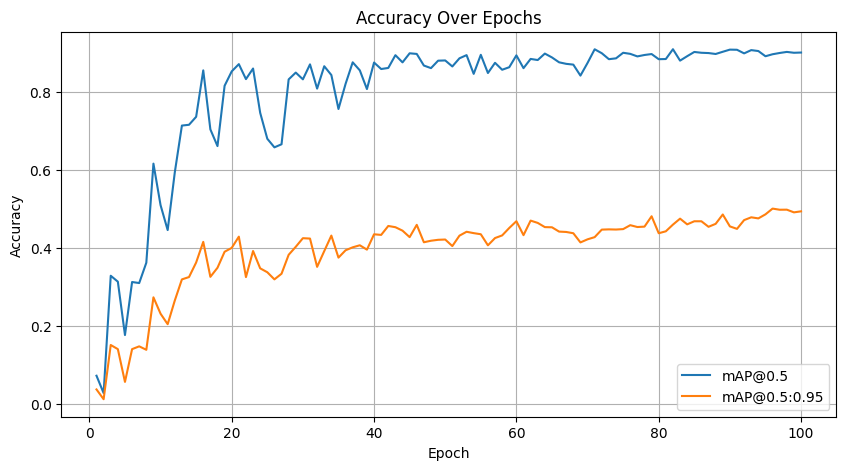

In [157]:
# Find recent training log dir
log_dir = max(glob('runs/detect/train*'), key=extract_number_from_str)

results = pd.read_csv(os.path.join(log_dir, 'results.csv'))
results.columns = results.columns.str.strip()

epochs = results.index + 1
mAP_0_5 = results['metrics/mAP50(B)']
mAP_0_5_0_95 = results['metrics/mAP50-95(B)']

plt.figure(figsize=(10, 5))
plt.plot(epochs, mAP_0_5, label='mAP@0.5')
plt.plot(epochs, mAP_0_5_0_95, label='mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [167]:
import numpy as np
from collections import defaultdict
from scipy.interpolate import interp1d

def calculate_iou(box1, box2):
    """Calculate Intersection over Union (IoU) between two boxes"""
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection = max(0, x2 - x1) * max(0, y2 - y1)

    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union = box1_area + box2_area - intersection

    return intersection / union if union > 0 else 0

def calculate_metrics(predictions, ground_truth, iou_thresholds=[0.5]):
    """
    Calculate precision, recall, mAP, and F1 score for object detection

    Args:
        predictions: List of dictionaries containing predicted boxes and scores
        ground_truth: List of dictionaries containing ground truth boxes
        iou_thresholds: List of IoU thresholds for evaluation

    Returns:
        Dictionary containing calculated metrics
    """
    metrics = defaultdict(dict)

    for iou_threshold in iou_thresholds:
        true_positives = []
        false_positives = []
        scores = []
        n_ground_truth = 0

        # Process each image
        for img_id in ground_truth:
            gt_boxes = ground_truth[img_id]
            pred_boxes = predictions.get(img_id, [])
            n_ground_truth += len(gt_boxes)

            # Mark ground truth boxes as not detected yet
            gt_matched = [False] * len(gt_boxes)

            # Sort predictions by confidence score
            pred_boxes = sorted(pred_boxes, key=lambda x: x['confidence'], reverse=True)

            for pred in pred_boxes:
                scores.append(pred['confidence'])
                max_iou = 0
                max_idx = -1

                # Find the best matching ground truth box
                for idx, gt_box in enumerate(gt_boxes):
                    if not gt_matched[idx]:
                        iou = calculate_iou(pred['bbox'], gt_box)
                        if iou > max_iou:
                            max_iou = iou
                            max_idx = idx

                if max_iou >= iou_threshold and max_idx >= 0:
                    true_positives.append(1)
                    false_positives.append(0)
                    gt_matched[max_idx] = True
                else:
                    true_positives.append(0)
                    false_positives.append(1)

        # Calculate cumulative precision and recall
        cumsum_tp = np.cumsum(true_positives)
        cumsum_fp = np.cumsum(false_positives)
        precision = cumsum_tp / (cumsum_tp + cumsum_fp)
        recall = cumsum_tp / n_ground_truth if n_ground_truth > 0 else np.zeros_like(cumsum_tp)

        # Calculate AP using 11-point interpolation
        ap = 0
        for t in np.arange(0, 1.1, 0.1):
            if np.sum(recall >= t) == 0:
                p = 0
            else:
                p = np.max(precision[recall >= t])
            ap += p / 11

        # Calculate F1 score
        f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
        max_f1 = np.max(f1) if len(f1) > 0 else 0

        metrics[f'mAP@{iou_threshold}'] = ap
        metrics[f'precision@{iou_threshold}'] = np.mean(precision)
        metrics[f'recall@{iou_threshold}'] = np.mean(recall)
        metrics[f'f1@{iou_threshold}'] = max_f1

    # Calculate mAP@0.5:0.95
    if len(iou_thresholds) > 1:
        metrics['mAP@0.5:0.95'] = np.mean([metrics[f'mAP@{t}'] for t in iou_thresholds])

    return metrics

def evaluate_model(model, test_df, output_dir='predictions'):
    """
    Evaluate model performance on test dataset

    Args:
        model: Trained YOLO model
        test_df: DataFrame containing test image paths
        output_dir: Directory to save results
    """
    # Get predictions
    predictions = {}
    ground_truth = {}

    # Process test images
    for idx, row in test_df.iterrows():
        img_path = row['img_path']
        img_name = os.path.basename(img_path)

        # Get model predictions
        results = model.predict(img_path, device='cuda' if torch.cuda.is_available() else 'cpu')

        # Store predictions
        predictions[img_name] = []
        for result in results:
            for box in result.boxes:
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                confidence = float(box.conf[0])
                predictions[img_name].append({
                    'bbox': [x1, y1, x2, y2],
                    'confidence': confidence
                })

        # Store ground truth
        ground_truth[img_name] = [[row['xmin'], row['ymin'], row['xmax'], row['ymax']]]

    # Calculate metrics for different IoU thresholds
    iou_thresholds = np.linspace(0.5, 0.95, 10)
    metrics = calculate_metrics(predictions, ground_truth, iou_thresholds)

    # Print results
    print("\nEvaluation Metrics:")
    print(f"mAP@0.5: {metrics['mAP@0.5']:.4f}")
    print(f"mAP@0.5:0.95: {metrics['mAP@0.5:0.95']:.4f}")
    print(f"Precision@0.5: {metrics['precision@0.5']:.4f}")
    print(f"Recall@0.5: {metrics['recall@0.5']:.4f}")
    print(f"F1@0.5: {metrics['f1@0.5']:.4f}")

    return metrics

In [168]:
evaluate_model(model, test)


image 1/1 /content/dataset/preprocessed_images/Cars425.png: 160x320 1 license_plate, 53.9ms
Speed: 1.5ms preprocess, 53.9ms inference, 1.2ms postprocess per image at shape (1, 3, 160, 320)

image 1/1 /content/dataset/preprocessed_images/Cars75.png: 224x320 1 license_plate, 50.5ms
Speed: 1.0ms preprocess, 50.5ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)

image 1/1 /content/dataset/preprocessed_images/Cars181.png: 320x192 1 license_plate, 44.9ms
Speed: 0.9ms preprocess, 44.9ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 192)

image 1/1 /content/dataset/preprocessed_images/Cars30.png: 192x320 2 license_plates, 43.6ms
Speed: 0.9ms preprocess, 43.6ms inference, 1.1ms postprocess per image at shape (1, 3, 192, 320)

image 1/1 /content/dataset/preprocessed_images/Cars364.png: 224x320 1 license_plate, 51.8ms
Speed: 1.0ms preprocess, 51.8ms inference, 1.2ms postprocess per image at shape (1, 3, 224, 320)

image 1/1 /content/dataset/preprocessed_images/Car

defaultdict(dict,
            {'mAP@0.5': 0.6088794926004228,
             'precision@0.5': 0.7362870874590688,
             'recall@0.5': 0.38054968287526436,
             'f1@0.5': 0.8045972012157948,
             'mAP@0.55': 0.5792811839323467,
             'precision@0.55': 0.6838982413629882,
             'recall@0.55': 0.3525369978858351,
             'f1@0.55': 0.7586201897215609,
             'mAP@0.6': 0.5792811839323467,
             'precision@0.6': 0.6838982413629882,
             'recall@0.6': 0.3525369978858351,
             'f1@0.6': 0.7586201897215609,
             'mAP@0.65': 0.5644820295983086,
             'precision@0.65': 0.679818254762821,
             'recall@0.65': 0.3488372093023256,
             'f1@0.65': 0.7356316839744447,
             'mAP@0.7': 0.46753246753246747,
             'precision@0.7': 0.6129715697323199,
             'recall@0.7': 0.3134249471458774,
             'f1@0.7': 0.6744181049219495,
             'mAP@0.75': 0.35064935064935066,
       

In [158]:
# save model
model.save('anpr-v1.pt')

# Test and predictions

In [159]:
# to predict test image
def predict_and_plot(path_test_car):

    results = model.predict(path_test_car, device='cpu')


    image = cv2.imread(path_test_car)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


    for result in results:
        for box in result.boxes:

            x1, y1, x2, y2 = map(int, box.xyxy[0])
            confidence = box.conf[0]

            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

            cv2.putText(image, f'{confidence*100:.2f}%', (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)


    plt.imshow(image)
    plt.axis('off')
    plt.show()


image 1/1 /content/dataset/preprocessed_images/Cars425.png: 160x320 1 license_plate, 39.1ms
Speed: 0.9ms preprocess, 39.1ms inference, 17.0ms postprocess per image at shape (1, 3, 160, 320)


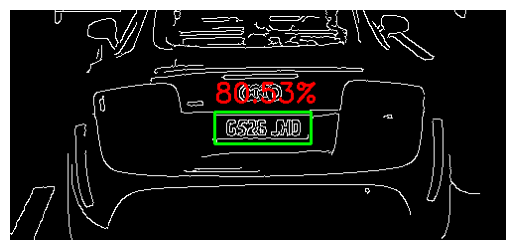

In [160]:
predict_and_plot(test.iloc[0].img_path)


image 1/1 /content/dataset/preprocessed_images/Cars181.png: 320x192 1 license_plate, 51.2ms
Speed: 0.9ms preprocess, 51.2ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 192)


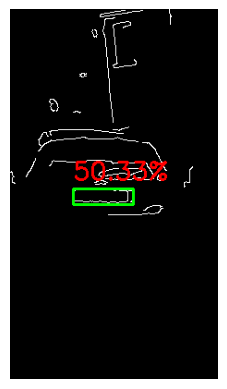

In [161]:
predict_and_plot(test.iloc[2].img_path)

## Testing

In [162]:
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

def batch_predict_and_save(model, test_df, output_dir='predictions'):
    """
    Run ANPR predictions on all images in the test dataset and save results

    Args:
        model: Trained YOLO model
        test_df: DataFrame containing test image paths
        output_dir: Directory to save annotated images
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Process all test images
    results_dict = {}

    for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Processing images"):
        img_path = row['img_path']
        img_name = os.path.basename(img_path)

        # Run prediction
        results = model.predict(img_path, device='cuda' if torch.cuda.is_available() else 'cpu')

        # Read and convert image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Store detection results
        detections = []

        # Draw bounding boxes and confidence scores
        for result in results:
            for box in result.boxes:
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                confidence = float(box.conf[0])

                # Draw rectangle and confidence score
                cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(image, f'{confidence*100:.2f}%',
                           (x1, y1 - 10),
                           cv2.FONT_HERSHEY_SIMPLEX,
                           0.9,
                           (255, 0, 0),
                           2)

                detections.append({
                    'bbox': [x1, y1, x2, y2],
                    'confidence': confidence
                })

        # Save results
        results_dict[img_name] = {
            'detections': detections,
            'original_path': img_path
        }

        # Save annotated image
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        plt.axis('off')
        plt.savefig(os.path.join(output_dir, f'annotated_{img_name}'),
                   bbox_inches='tight',
                   pad_inches=0)
        plt.close()

    return results_dict

# Function to display summary statistics
def display_detection_stats(results_dict):
    """
    Display summary statistics for the batch predictions

    Args:
        results_dict: Dictionary containing detection results
    """
    total_images = len(results_dict)
    images_with_detections = sum(1 for v in results_dict.values() if v['detections'])
    total_detections = sum(len(v['detections']) for v in results_dict.values())
    avg_confidence = np.mean([d['confidence']
                            for v in results_dict.values()
                            for d in v['detections']]) if total_detections > 0 else 0

    print(f"Detection Summary:")
    print(f"Total images processed: {total_images}")
    print(f"Images with detections: {images_with_detections}")
    print(f"Total license plates detected: {total_detections}")
    print(f"Average confidence score: {avg_confidence*100:.2f}%")

# Usage example
def run_batch_detection(model, test_df):
    """
    Run the complete batch detection pipeline

    Args:
        model: Trained YOLO model
        test_df: DataFrame containing test image paths
    """
    print("Starting batch license plate detection...")

    # Run predictions on all images
    results = batch_predict_and_save(model, test_df)

    # Display statistics
    display_detection_stats(results)

    print(f"\nPredictions saved in 'predictions' directory")
    return results

In [165]:
# Assign train to train_data
train_data = train

# Run batch prediction
run_batch_detection(model=model, test_df=train_data)

Starting batch license plate detection...


Processing images:   0%|          | 0/345 [00:00<?, ?it/s]


image 1/1 /content/dataset/preprocessed_images/Cars124.png: 224x320 1 license_plate, 68.0ms
Speed: 1.3ms preprocess, 68.0ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)


Processing images:   0%|          | 1/345 [00:00<02:13,  2.58it/s]


image 1/1 /content/dataset/preprocessed_images/Cars315.png: 256x320 1 license_plate, 66.8ms
Speed: 1.1ms preprocess, 66.8ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 320)


Processing images:   1%|          | 2/345 [00:00<02:11,  2.61it/s]


image 1/1 /content/dataset/preprocessed_images/Cars282.png: 256x320 1 license_plate, 53.4ms
Speed: 1.2ms preprocess, 53.4ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 320)


Processing images:   1%|          | 3/345 [00:01<02:13,  2.57it/s]


image 1/1 /content/dataset/preprocessed_images/Cars236.png: 160x320 1 license_plate, 44.1ms
Speed: 0.8ms preprocess, 44.1ms inference, 0.9ms postprocess per image at shape (1, 3, 160, 320)


Processing images:   1%|          | 4/345 [00:01<02:01,  2.80it/s]


image 1/1 /content/dataset/preprocessed_images/Cars112.png: 320x192 1 license_plate, 50.3ms
Speed: 0.9ms preprocess, 50.3ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 192)


Processing images:   1%|▏         | 5/345 [00:01<01:59,  2.85it/s]


image 1/1 /content/dataset/preprocessed_images/Cars402.png: 192x320 1 license_plate, 43.8ms
Speed: 0.9ms preprocess, 43.8ms inference, 0.9ms postprocess per image at shape (1, 3, 192, 320)


Processing images:   2%|▏         | 6/345 [00:02<01:59,  2.84it/s]


image 1/1 /content/dataset/preprocessed_images/Cars105.png: 192x320 2 license_plates, 50.9ms
Speed: 1.2ms preprocess, 50.9ms inference, 1.1ms postprocess per image at shape (1, 3, 192, 320)


Processing images:   2%|▏         | 7/345 [00:02<01:52,  3.01it/s]


image 1/1 /content/dataset/preprocessed_images/Cars358.png: 160x320 2 license_plates, 27.3ms
Speed: 0.7ms preprocess, 27.3ms inference, 0.7ms postprocess per image at shape (1, 3, 160, 320)


Processing images:   2%|▏         | 8/345 [00:02<01:40,  3.36it/s]


image 1/1 /content/dataset/preprocessed_images/Cars180.png: 256x320 1 license_plate, 36.3ms
Speed: 0.8ms preprocess, 36.3ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 320)


Processing images:   3%|▎         | 9/345 [00:02<01:35,  3.50it/s]


image 1/1 /content/dataset/preprocessed_images/Cars280.png: 224x320 1 license_plate, 31.0ms
Speed: 0.7ms preprocess, 31.0ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 320)


Processing images:   3%|▎         | 10/345 [00:03<01:37,  3.44it/s]


image 1/1 /content/dataset/preprocessed_images/Cars265.png: 192x320 1 license_plate, 29.5ms
Speed: 0.9ms preprocess, 29.5ms inference, 0.8ms postprocess per image at shape (1, 3, 192, 320)


Processing images:   3%|▎         | 11/345 [00:03<01:30,  3.70it/s]


image 1/1 /content/dataset/preprocessed_images/Cars230.png: 192x320 1 license_plate, 30.1ms
Speed: 0.6ms preprocess, 30.1ms inference, 0.7ms postprocess per image at shape (1, 3, 192, 320)


Processing images:   3%|▎         | 12/345 [00:03<01:28,  3.77it/s]


image 1/1 /content/dataset/preprocessed_images/Cars386.png: 256x320 1 license_plate, 38.9ms
Speed: 0.9ms preprocess, 38.9ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 320)


Processing images:   4%|▍         | 13/345 [00:03<01:28,  3.74it/s]


image 1/1 /content/dataset/preprocessed_images/Cars275.png: 192x320 1 license_plate, 32.9ms
Speed: 0.6ms preprocess, 32.9ms inference, 0.7ms postprocess per image at shape (1, 3, 192, 320)


Processing images:   4%|▍         | 14/345 [00:04<01:25,  3.87it/s]


image 1/1 /content/dataset/preprocessed_images/Cars424.png: 256x320 1 license_plate, 35.6ms
Speed: 0.8ms preprocess, 35.6ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 320)


Processing images:   4%|▍         | 15/345 [00:04<01:26,  3.84it/s]


image 1/1 /content/dataset/preprocessed_images/Cars11.png: 256x320 1 license_plate, 33.6ms
Speed: 0.8ms preprocess, 33.6ms inference, 0.6ms postprocess per image at shape (1, 3, 256, 320)


Processing images:   5%|▍         | 16/345 [00:04<01:26,  3.79it/s]


image 1/1 /content/dataset/preprocessed_images/Cars390.png: 256x320 1 license_plate, 34.3ms
Speed: 0.9ms preprocess, 34.3ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 320)


Processing images:   5%|▍         | 17/345 [00:05<01:26,  3.79it/s]


image 1/1 /content/dataset/preprocessed_images/Cars51.png: 224x320 1 license_plate, 32.8ms
Speed: 0.7ms preprocess, 32.8ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 320)


Processing images:   5%|▌         | 18/345 [00:05<01:25,  3.83it/s]


image 1/1 /content/dataset/preprocessed_images/Cars309.png: 192x320 1 license_plate, 28.8ms
Speed: 2.0ms preprocess, 28.8ms inference, 0.7ms postprocess per image at shape (1, 3, 192, 320)


Processing images:   6%|▌         | 19/345 [00:05<01:21,  4.01it/s]


image 1/1 /content/dataset/preprocessed_images/Cars226.png: 224x320 1 license_plate, 33.6ms
Speed: 0.7ms preprocess, 33.6ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 320)


Processing images:   6%|▌         | 20/345 [00:05<01:21,  3.97it/s]


image 1/1 /content/dataset/preprocessed_images/Cars273.png: 192x320 1 license_plate, 29.0ms
Speed: 0.7ms preprocess, 29.0ms inference, 0.7ms postprocess per image at shape (1, 3, 192, 320)


Processing images:   6%|▌         | 21/345 [00:06<01:20,  4.02it/s]


image 1/1 /content/dataset/preprocessed_images/Cars380.png: 192x320 1 license_plate, 27.5ms
Speed: 0.9ms preprocess, 27.5ms inference, 0.7ms postprocess per image at shape (1, 3, 192, 320)


Processing images:   6%|▋         | 22/345 [00:06<01:18,  4.12it/s]


image 1/1 /content/dataset/preprocessed_images/Cars31.png: 224x320 1 license_plate, 32.1ms
Speed: 1.3ms preprocess, 32.1ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 320)


Processing images:   7%|▋         | 23/345 [00:06<01:17,  4.14it/s]


image 1/1 /content/dataset/preprocessed_images/Cars418.png: 192x320 1 license_plate, 31.7ms
Speed: 0.6ms preprocess, 31.7ms inference, 0.7ms postprocess per image at shape (1, 3, 192, 320)


Processing images:   7%|▋         | 24/345 [00:06<01:16,  4.22it/s]


image 1/1 /content/dataset/preprocessed_images/Cars257.png: 256x320 1 license_plate, 33.7ms
Speed: 0.8ms preprocess, 33.7ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 320)


Processing images:   7%|▋         | 25/345 [00:06<01:18,  4.10it/s]


image 1/1 /content/dataset/preprocessed_images/Cars92.png: 224x320 1 license_plate, 32.0ms
Speed: 1.0ms preprocess, 32.0ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 320)


Processing images:   8%|▊         | 26/345 [00:07<01:19,  4.02it/s]


image 1/1 /content/dataset/preprocessed_images/Cars344.png: 224x320 1 license_plate, 33.8ms
Speed: 1.0ms preprocess, 33.8ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 320)


Processing images:   8%|▊         | 27/345 [00:07<01:20,  3.97it/s]


image 1/1 /content/dataset/preprocessed_images/Cars26.png: 192x320 1 license_plate, 29.1ms
Speed: 0.7ms preprocess, 29.1ms inference, 0.7ms postprocess per image at shape (1, 3, 192, 320)


Processing images:   8%|▊         | 28/345 [00:07<01:18,  4.06it/s]


image 1/1 /content/dataset/preprocessed_images/Cars157.png: 224x320 2 license_plates, 33.6ms
Speed: 0.9ms preprocess, 33.6ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 320)


Processing images:   8%|▊         | 29/345 [00:07<01:18,  4.03it/s]


image 1/1 /content/dataset/preprocessed_images/Cars76.png: 256x320 1 license_plate, 48.3ms
Speed: 1.2ms preprocess, 48.3ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 320)


Processing images:   9%|▊         | 30/345 [00:08<01:21,  3.85it/s]


image 1/1 /content/dataset/preprocessed_images/Cars79.png: 288x320 1 license_plate, 41.8ms
Speed: 1.0ms preprocess, 41.8ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 320)


Processing images:   9%|▉         | 31/345 [00:08<01:25,  3.66it/s]


image 1/1 /content/dataset/preprocessed_images/Cars427.png: 256x320 1 license_plate, 33.1ms
Speed: 1.0ms preprocess, 33.1ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 320)


Processing images:   9%|▉         | 32/345 [00:08<01:25,  3.67it/s]


image 1/1 /content/dataset/preprocessed_images/Cars74.png: 224x320 1 license_plate, 31.1ms
Speed: 0.8ms preprocess, 31.1ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  10%|▉         | 33/345 [00:09<01:23,  3.76it/s]


image 1/1 /content/dataset/preprocessed_images/Cars41.png: 320x256 1 license_plate, 34.1ms
Speed: 0.9ms preprocess, 34.1ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 256)


Processing images:  10%|▉         | 34/345 [00:09<01:23,  3.73it/s]


image 1/1 /content/dataset/preprocessed_images/Cars310.png: 288x320 1 license_plate, 40.8ms
Speed: 0.9ms preprocess, 40.8ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 320)


Processing images:  10%|█         | 35/345 [00:09<01:26,  3.59it/s]


image 1/1 /content/dataset/preprocessed_images/Cars242.png: 320x320 1 license_plate, 38.0ms
Speed: 1.6ms preprocess, 38.0ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 320)


Processing images:  10%|█         | 36/345 [00:09<01:29,  3.46it/s]


image 1/1 /content/dataset/preprocessed_images/Cars406.png: 224x320 1 license_plate, 32.0ms
Speed: 0.9ms preprocess, 32.0ms inference, 0.8ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  11%|█         | 37/345 [00:10<01:26,  3.58it/s]


image 1/1 /content/dataset/preprocessed_images/Cars145.png: 224x320 1 license_plate, 30.9ms
Speed: 0.9ms preprocess, 30.9ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  11%|█         | 38/345 [00:10<01:23,  3.70it/s]


image 1/1 /content/dataset/preprocessed_images/Cars189.png: 224x320 1 license_plate, 33.5ms
Speed: 0.8ms preprocess, 33.5ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  11%|█▏        | 39/345 [00:10<01:21,  3.77it/s]


image 1/1 /content/dataset/preprocessed_images/Cars291.png: 192x320 1 license_plate, 27.3ms
Speed: 1.1ms preprocess, 27.3ms inference, 0.6ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  12%|█▏        | 40/345 [00:10<01:18,  3.88it/s]


image 1/1 /content/dataset/preprocessed_images/Cars176.png: 224x320 1 license_plate, 32.8ms
Speed: 1.1ms preprocess, 32.8ms inference, 0.8ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  12%|█▏        | 41/345 [00:11<01:16,  3.95it/s]


image 1/1 /content/dataset/preprocessed_images/Cars232.png: 256x320 1 license_plate, 32.4ms
Speed: 0.8ms preprocess, 32.4ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  12%|█▏        | 42/345 [00:11<01:16,  3.95it/s]


image 1/1 /content/dataset/preprocessed_images/Cars381.png: 192x320 1 license_plate, 28.0ms
Speed: 0.8ms preprocess, 28.0ms inference, 0.7ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  12%|█▏        | 43/345 [00:11<01:14,  4.08it/s]


image 1/1 /content/dataset/preprocessed_images/Cars222.png: 192x320 1 license_plate, 26.5ms
Speed: 0.9ms preprocess, 26.5ms inference, 0.7ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  13%|█▎        | 44/345 [00:11<01:11,  4.19it/s]


image 1/1 /content/dataset/preprocessed_images/Cars44.png: 256x320 1 license_plate, 35.8ms
Speed: 0.9ms preprocess, 35.8ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  13%|█▎        | 45/345 [00:12<01:15,  3.98it/s]


image 1/1 /content/dataset/preprocessed_images/Cars313.png: 256x320 1 license_plate, 34.4ms
Speed: 1.0ms preprocess, 34.4ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  13%|█▎        | 46/345 [00:12<01:20,  3.72it/s]


image 1/1 /content/dataset/preprocessed_images/Cars296.png: 256x320 1 license_plate, 52.2ms
Speed: 1.3ms preprocess, 52.2ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  14%|█▎        | 47/345 [00:12<01:33,  3.20it/s]


image 1/1 /content/dataset/preprocessed_images/Cars303.png: 256x320 1 license_plate, 52.1ms
Speed: 1.4ms preprocess, 52.1ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  14%|█▍        | 48/345 [00:13<01:40,  2.96it/s]


image 1/1 /content/dataset/preprocessed_images/Cars301.png: 160x320 1 license_plate, 37.1ms
Speed: 0.8ms preprocess, 37.1ms inference, 0.8ms postprocess per image at shape (1, 3, 160, 320)


Processing images:  14%|█▍        | 49/345 [00:13<01:36,  3.06it/s]


image 1/1 /content/dataset/preprocessed_images/Cars379.png: 288x320 1 license_plate, 56.5ms
Speed: 1.2ms preprocess, 56.5ms inference, 1.9ms postprocess per image at shape (1, 3, 288, 320)


Processing images:  14%|█▍        | 50/345 [00:14<01:45,  2.81it/s]


image 1/1 /content/dataset/preprocessed_images/Cars350.png: 224x320 1 license_plate, 52.7ms
Speed: 1.1ms preprocess, 52.7ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  15%|█▍        | 51/345 [00:14<01:42,  2.86it/s]


image 1/1 /content/dataset/preprocessed_images/Cars361.png: 256x320 1 license_plate, 48.1ms
Speed: 1.1ms preprocess, 48.1ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  15%|█▌        | 52/345 [00:14<01:42,  2.85it/s]


image 1/1 /content/dataset/preprocessed_images/Cars137.png: 224x320 1 license_plate, 43.8ms
Speed: 1.1ms preprocess, 43.8ms inference, 0.8ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  15%|█▌        | 53/345 [00:15<01:41,  2.88it/s]


image 1/1 /content/dataset/preprocessed_images/Cars248.png: 256x320 1 license_plate, 52.7ms
Speed: 1.2ms preprocess, 52.7ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  16%|█▌        | 54/345 [00:15<01:43,  2.80it/s]


image 1/1 /content/dataset/preprocessed_images/Cars239.png: 256x320 1 license_plate, 53.0ms
Speed: 1.3ms preprocess, 53.0ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  16%|█▌        | 55/345 [00:15<01:46,  2.74it/s]


image 1/1 /content/dataset/preprocessed_images/Cars90.png: 256x320 1 license_plate, 54.3ms
Speed: 1.3ms preprocess, 54.3ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  16%|█▌        | 56/345 [00:16<01:51,  2.59it/s]


image 1/1 /content/dataset/preprocessed_images/Cars256.png: 224x320 1 license_plate, 51.1ms
Speed: 2.3ms preprocess, 51.1ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  17%|█▋        | 57/345 [00:16<01:47,  2.68it/s]


image 1/1 /content/dataset/preprocessed_images/Cars359.png: 256x320 1 license_plate, 51.8ms
Speed: 1.1ms preprocess, 51.8ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  17%|█▋        | 58/345 [00:16<01:47,  2.67it/s]


image 1/1 /content/dataset/preprocessed_images/Cars88.png: 256x320 1 license_plate, 53.9ms
Speed: 1.1ms preprocess, 53.9ms inference, 4.0ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  17%|█▋        | 59/345 [00:17<01:49,  2.61it/s]


image 1/1 /content/dataset/preprocessed_images/Cars205.png: 320x320 2 license_plates, 56.4ms
Speed: 1.4ms preprocess, 56.4ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 320)


Processing images:  17%|█▋        | 60/345 [00:17<01:55,  2.46it/s]


image 1/1 /content/dataset/preprocessed_images/Cars314.png: 192x320 1 license_plate, 44.6ms
Speed: 0.9ms preprocess, 44.6ms inference, 0.9ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  18%|█▊        | 61/345 [00:18<01:50,  2.57it/s]


image 1/1 /content/dataset/preprocessed_images/Cars162.png: 192x320 1 license_plate, 42.8ms
Speed: 1.0ms preprocess, 42.8ms inference, 0.9ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  18%|█▊        | 62/345 [00:18<01:46,  2.67it/s]


image 1/1 /content/dataset/preprocessed_images/Cars99.png: 320x256 1 license_plate, 52.6ms
Speed: 1.2ms preprocess, 52.6ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 256)


Processing images:  18%|█▊        | 63/345 [00:18<01:49,  2.58it/s]


image 1/1 /content/dataset/preprocessed_images/Cars64.png: 224x320 1 license_plate, 52.6ms
Speed: 1.2ms preprocess, 52.6ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  19%|█▊        | 64/345 [00:19<01:49,  2.56it/s]


image 1/1 /content/dataset/preprocessed_images/Cars16.png: 192x320 (no detections), 47.2ms
Speed: 5.5ms preprocess, 47.2ms inference, 0.6ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  19%|█▉        | 65/345 [00:19<01:44,  2.69it/s]


image 1/1 /content/dataset/preprocessed_images/Cars7.png: 224x320 1 license_plate, 48.8ms
Speed: 1.1ms preprocess, 48.8ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  19%|█▉        | 66/345 [00:20<01:46,  2.62it/s]


image 1/1 /content/dataset/preprocessed_images/Cars191.png: 224x320 1 license_plate, 53.6ms
Speed: 1.2ms preprocess, 53.6ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  19%|█▉        | 67/345 [00:20<01:46,  2.62it/s]


image 1/1 /content/dataset/preprocessed_images/Cars6.png: 256x320 1 license_plate, 52.4ms
Speed: 1.2ms preprocess, 52.4ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  20%|█▉        | 68/345 [00:20<01:47,  2.58it/s]


image 1/1 /content/dataset/preprocessed_images/Cars142.png: 160x320 1 license_plate, 39.2ms
Speed: 0.8ms preprocess, 39.2ms inference, 0.9ms postprocess per image at shape (1, 3, 160, 320)


Processing images:  20%|██        | 69/345 [00:21<01:41,  2.71it/s]


image 1/1 /content/dataset/preprocessed_images/Cars179.png: 224x320 1 license_plate, 54.6ms
Speed: 1.2ms preprocess, 54.6ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  20%|██        | 70/345 [00:21<01:42,  2.69it/s]


image 1/1 /content/dataset/preprocessed_images/Cars209.png: 256x320 1 license_plate, 52.6ms
Speed: 1.1ms preprocess, 52.6ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  21%|██        | 71/345 [00:21<01:41,  2.70it/s]


image 1/1 /content/dataset/preprocessed_images/Cars285.png: 224x320 1 license_plate, 50.2ms
Speed: 1.1ms preprocess, 50.2ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  21%|██        | 72/345 [00:22<01:34,  2.89it/s]


image 1/1 /content/dataset/preprocessed_images/Cars300.png: 192x320 1 license_plate, 30.5ms
Speed: 1.1ms preprocess, 30.5ms inference, 0.7ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  21%|██        | 73/345 [00:22<01:24,  3.20it/s]


image 1/1 /content/dataset/preprocessed_images/Cars153.png: 192x320 1 license_plate, 29.3ms
Speed: 1.0ms preprocess, 29.3ms inference, 0.8ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  21%|██▏       | 74/345 [00:22<01:17,  3.49it/s]


image 1/1 /content/dataset/preprocessed_images/Cars121.png: 256x320 1 license_plate, 33.9ms
Speed: 0.7ms preprocess, 33.9ms inference, 0.6ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  22%|██▏       | 75/345 [00:22<01:15,  3.58it/s]


image 1/1 /content/dataset/preprocessed_images/Cars166.png: 320x256 1 license_plate, 33.3ms
Speed: 0.7ms preprocess, 33.3ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 256)


Processing images:  22%|██▏       | 76/345 [00:23<01:14,  3.62it/s]


image 1/1 /content/dataset/preprocessed_images/Cars61.png: 256x320 1 license_plate, 42.0ms
Speed: 1.4ms preprocess, 42.0ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  22%|██▏       | 77/345 [00:23<01:15,  3.57it/s]


image 1/1 /content/dataset/preprocessed_images/Cars62.png: 256x320 1 license_plate, 36.1ms
Speed: 1.2ms preprocess, 36.1ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  23%|██▎       | 78/345 [00:23<01:14,  3.61it/s]


image 1/1 /content/dataset/preprocessed_images/Cars252.png: 256x320 1 license_plate, 34.4ms
Speed: 0.9ms preprocess, 34.4ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  23%|██▎       | 79/345 [00:24<01:13,  3.63it/s]


image 1/1 /content/dataset/preprocessed_images/Cars227.png: 224x320 3 license_plates, 35.5ms
Speed: 1.0ms preprocess, 35.5ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  23%|██▎       | 80/345 [00:24<01:12,  3.67it/s]


image 1/1 /content/dataset/preprocessed_images/Cars202.png: 256x320 1 license_plate, 34.7ms
Speed: 1.1ms preprocess, 34.7ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  23%|██▎       | 81/345 [00:24<01:11,  3.70it/s]


image 1/1 /content/dataset/preprocessed_images/Cars422.png: 192x320 1 license_plate, 28.6ms
Speed: 0.7ms preprocess, 28.6ms inference, 0.7ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  24%|██▍       | 82/345 [00:24<01:08,  3.85it/s]


image 1/1 /content/dataset/preprocessed_images/Cars71.png: 192x320 1 license_plate, 28.2ms
Speed: 1.0ms preprocess, 28.2ms inference, 0.6ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  24%|██▍       | 83/345 [00:25<01:05,  4.00it/s]


image 1/1 /content/dataset/preprocessed_images/Cars81.png: 256x320 1 license_plate, 33.1ms
Speed: 1.1ms preprocess, 33.1ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  24%|██▍       | 84/345 [00:25<01:06,  3.94it/s]


image 1/1 /content/dataset/preprocessed_images/Cars133.png: 224x320 1 license_plate, 35.3ms
Speed: 1.2ms preprocess, 35.3ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  25%|██▍       | 85/345 [00:25<01:08,  3.78it/s]


image 1/1 /content/dataset/preprocessed_images/Cars170.png: 256x320 1 license_plate, 48.9ms
Speed: 1.4ms preprocess, 48.9ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  25%|██▍       | 86/345 [00:25<01:10,  3.65it/s]


image 1/1 /content/dataset/preprocessed_images/Cars333.png: 224x320 1 license_plate, 33.1ms
Speed: 1.1ms preprocess, 33.1ms inference, 0.8ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  25%|██▌       | 87/345 [00:26<01:09,  3.71it/s]


image 1/1 /content/dataset/preprocessed_images/Cars138.png: 256x320 2 license_plates, 42.3ms
Speed: 1.2ms preprocess, 42.3ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  26%|██▌       | 88/345 [00:26<01:09,  3.70it/s]


image 1/1 /content/dataset/preprocessed_images/Cars410.png: 320x256 1 license_plate, 35.5ms
Speed: 0.8ms preprocess, 35.5ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 256)


Processing images:  26%|██▌       | 89/345 [00:26<01:08,  3.73it/s]


image 1/1 /content/dataset/preprocessed_images/Cars10.png: 192x320 1 license_plate, 27.6ms
Speed: 1.3ms preprocess, 27.6ms inference, 0.7ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  26%|██▌       | 90/345 [00:26<01:04,  3.95it/s]


image 1/1 /content/dataset/preprocessed_images/Cars238.png: 224x320 1 license_plate, 33.1ms
Speed: 1.1ms preprocess, 33.1ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  26%|██▋       | 91/345 [00:27<01:05,  3.87it/s]


image 1/1 /content/dataset/preprocessed_images/Cars216.png: 256x320 1 license_plate, 32.5ms
Speed: 1.3ms preprocess, 32.5ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  27%|██▋       | 92/345 [00:27<01:06,  3.80it/s]


image 1/1 /content/dataset/preprocessed_images/Cars94.png: 256x320 1 license_plate, 32.5ms
Speed: 1.1ms preprocess, 32.5ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  27%|██▋       | 93/345 [00:27<01:06,  3.79it/s]


image 1/1 /content/dataset/preprocessed_images/Cars288.png: 192x320 1 license_plate, 30.8ms
Speed: 1.3ms preprocess, 30.8ms inference, 0.7ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  27%|██▋       | 94/345 [00:27<01:02,  3.99it/s]


image 1/1 /content/dataset/preprocessed_images/Cars149.png: 256x320 1 license_plate, 37.1ms
Speed: 1.1ms preprocess, 37.1ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  28%|██▊       | 95/345 [00:28<01:04,  3.89it/s]


image 1/1 /content/dataset/preprocessed_images/Cars212.png: 256x320 1 license_plate, 31.7ms
Speed: 1.1ms preprocess, 31.7ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  28%|██▊       | 96/345 [00:28<01:04,  3.84it/s]


image 1/1 /content/dataset/preprocessed_images/Cars188.png: 320x256 (no detections), 35.9ms
Speed: 1.3ms preprocess, 35.9ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 256)


Processing images:  28%|██▊       | 97/345 [00:28<01:04,  3.82it/s]


image 1/1 /content/dataset/preprocessed_images/Cars383.png: 224x320 2 license_plates, 37.6ms
Speed: 1.0ms preprocess, 37.6ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  28%|██▊       | 98/345 [00:28<01:04,  3.86it/s]


image 1/1 /content/dataset/preprocessed_images/Cars119.png: 224x320 1 license_plate, 32.3ms
Speed: 1.0ms preprocess, 32.3ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  29%|██▊       | 99/345 [00:29<01:02,  3.92it/s]


image 1/1 /content/dataset/preprocessed_images/Cars123.png: 256x320 1 license_plate, 34.7ms
Speed: 1.1ms preprocess, 34.7ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  29%|██▉       | 100/345 [00:29<01:03,  3.88it/s]


image 1/1 /content/dataset/preprocessed_images/Cars426.png: 256x320 1 license_plate, 37.1ms
Speed: 1.2ms preprocess, 37.1ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  29%|██▉       | 101/345 [00:29<01:03,  3.84it/s]


image 1/1 /content/dataset/preprocessed_images/Cars15.png: 224x320 1 license_plate, 34.0ms
Speed: 1.4ms preprocess, 34.0ms inference, 0.8ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  30%|██▉       | 102/345 [00:30<01:02,  3.87it/s]


image 1/1 /content/dataset/preprocessed_images/Cars251.png: 192x320 (no detections), 36.3ms
Speed: 1.0ms preprocess, 36.3ms inference, 0.4ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  30%|██▉       | 103/345 [00:30<01:01,  3.93it/s]


image 1/1 /content/dataset/preprocessed_images/Cars371.png: 160x320 1 license_plate, 27.4ms
Speed: 0.8ms preprocess, 27.4ms inference, 0.7ms postprocess per image at shape (1, 3, 160, 320)


Processing images:  30%|███       | 104/345 [00:30<00:57,  4.19it/s]


image 1/1 /content/dataset/preprocessed_images/Cars19.png: 192x320 1 license_plate, 32.8ms
Speed: 1.1ms preprocess, 32.8ms inference, 0.7ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  30%|███       | 105/345 [00:30<00:57,  4.16it/s]


image 1/1 /content/dataset/preprocessed_images/Cars385.png: 224x320 1 license_plate, 36.3ms
Speed: 1.4ms preprocess, 36.3ms inference, 1.2ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  31%|███       | 106/345 [00:30<00:58,  4.12it/s]


image 1/1 /content/dataset/preprocessed_images/Cars327.png: 224x320 1 license_plate, 35.2ms
Speed: 2.2ms preprocess, 35.2ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  31%|███       | 107/345 [00:31<00:58,  4.05it/s]


image 1/1 /content/dataset/preprocessed_images/Cars394.png: 256x320 1 license_plate, 35.5ms
Speed: 1.1ms preprocess, 35.5ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  31%|███▏      | 108/345 [00:31<01:01,  3.85it/s]


image 1/1 /content/dataset/preprocessed_images/Cars217.png: 192x320 1 license_plate, 27.6ms
Speed: 1.0ms preprocess, 27.6ms inference, 0.6ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  32%|███▏      | 109/345 [00:31<00:59,  3.95it/s]


image 1/1 /content/dataset/preprocessed_images/Cars322.png: 288x320 1 license_plate, 37.2ms
Speed: 1.3ms preprocess, 37.2ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 320)


Processing images:  32%|███▏      | 110/345 [00:32<01:01,  3.80it/s]


image 1/1 /content/dataset/preprocessed_images/Cars367.png: 224x320 1 license_plate, 46.7ms
Speed: 1.1ms preprocess, 46.7ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  32%|███▏      | 111/345 [00:32<01:10,  3.33it/s]


image 1/1 /content/dataset/preprocessed_images/Cars197.png: 192x320 1 license_plate, 41.3ms
Speed: 1.3ms preprocess, 41.3ms inference, 0.9ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  32%|███▏      | 112/345 [00:32<01:10,  3.31it/s]


image 1/1 /content/dataset/preprocessed_images/Cars276.png: 224x320 1 license_plate, 50.7ms
Speed: 1.0ms preprocess, 50.7ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  33%|███▎      | 113/345 [00:33<01:16,  3.02it/s]


image 1/1 /content/dataset/preprocessed_images/Cars378.png: 256x320 1 license_plate, 54.3ms
Speed: 1.1ms preprocess, 54.3ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  33%|███▎      | 114/345 [00:33<01:16,  3.01it/s]


image 1/1 /content/dataset/preprocessed_images/Cars420.png: 256x320 1 license_plate, 55.6ms
Speed: 1.2ms preprocess, 55.6ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  33%|███▎      | 115/345 [00:33<01:22,  2.80it/s]


image 1/1 /content/dataset/preprocessed_images/Cars125.png: 224x320 1 license_plate, 47.2ms
Speed: 1.4ms preprocess, 47.2ms inference, 0.8ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  34%|███▎      | 116/345 [00:34<01:23,  2.74it/s]


image 1/1 /content/dataset/preprocessed_images/Cars347.png: 192x320 1 license_plate, 43.6ms
Speed: 0.8ms preprocess, 43.6ms inference, 0.9ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  34%|███▍      | 117/345 [00:34<01:17,  2.94it/s]


image 1/1 /content/dataset/preprocessed_images/Cars136.png: 224x320 1 license_plate, 51.7ms
Speed: 1.0ms preprocess, 51.7ms inference, 0.8ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  34%|███▍      | 118/345 [00:34<01:18,  2.89it/s]


image 1/1 /content/dataset/preprocessed_images/Cars311.png: 224x320 1 license_plate, 49.7ms
Speed: 1.1ms preprocess, 49.7ms inference, 0.8ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  34%|███▍      | 119/345 [00:35<01:21,  2.76it/s]


image 1/1 /content/dataset/preprocessed_images/Cars117.png: 160x320 1 license_plate, 41.8ms
Speed: 0.9ms preprocess, 41.8ms inference, 0.9ms postprocess per image at shape (1, 3, 160, 320)


Processing images:  35%|███▍      | 120/345 [00:35<01:17,  2.90it/s]


image 1/1 /content/dataset/preprocessed_images/Cars317.png: 256x320 1 license_plate, 58.1ms
Speed: 1.2ms preprocess, 58.1ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  35%|███▌      | 121/345 [00:35<01:19,  2.82it/s]


image 1/1 /content/dataset/preprocessed_images/Cars218.png: 224x320 (no detections), 50.9ms
Speed: 1.0ms preprocess, 50.9ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  35%|███▌      | 122/345 [00:36<01:21,  2.74it/s]


image 1/1 /content/dataset/preprocessed_images/Cars167.png: 256x320 1 license_plate, 52.0ms
Speed: 1.3ms preprocess, 52.0ms inference, 2.7ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  36%|███▌      | 123/345 [00:36<01:25,  2.60it/s]


image 1/1 /content/dataset/preprocessed_images/Cars156.png: 160x320 1 license_plate, 39.0ms
Speed: 0.8ms preprocess, 39.0ms inference, 0.9ms postprocess per image at shape (1, 3, 160, 320)


Processing images:  36%|███▌      | 124/345 [00:37<01:20,  2.74it/s]


image 1/1 /content/dataset/preprocessed_images/Cars338.png: 224x320 (no detections), 70.3ms
Speed: 1.1ms preprocess, 70.3ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  36%|███▌      | 125/345 [00:37<01:19,  2.76it/s]


image 1/1 /content/dataset/preprocessed_images/Cars80.png: 256x320 1 license_plate, 55.1ms
Speed: 1.1ms preprocess, 55.1ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  37%|███▋      | 126/345 [00:37<01:21,  2.67it/s]


image 1/1 /content/dataset/preprocessed_images/Cars210.png: 224x320 1 license_plate, 67.5ms
Speed: 1.0ms preprocess, 67.5ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  37%|███▋      | 127/345 [00:38<01:24,  2.57it/s]


image 1/1 /content/dataset/preprocessed_images/Cars249.png: 224x320 2 license_plates, 64.9ms
Speed: 1.0ms preprocess, 64.9ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  37%|███▋      | 128/345 [00:38<01:27,  2.49it/s]


image 1/1 /content/dataset/preprocessed_images/Cars382.png: 256x320 1 license_plate, 59.5ms
Speed: 1.1ms preprocess, 59.5ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  37%|███▋      | 129/345 [00:39<01:28,  2.44it/s]


image 1/1 /content/dataset/preprocessed_images/Cars407.png: 224x320 1 license_plate, 48.3ms
Speed: 1.2ms preprocess, 48.3ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  38%|███▊      | 130/345 [00:39<01:26,  2.48it/s]


image 1/1 /content/dataset/preprocessed_images/Cars139.png: 256x320 1 license_plate, 58.9ms
Speed: 1.3ms preprocess, 58.9ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  38%|███▊      | 131/345 [00:40<01:29,  2.38it/s]


image 1/1 /content/dataset/preprocessed_images/Cars60.png: 256x320 1 license_plate, 58.3ms
Speed: 1.1ms preprocess, 58.3ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  38%|███▊      | 132/345 [00:40<01:28,  2.41it/s]


image 1/1 /content/dataset/preprocessed_images/Cars413.png: 224x320 1 license_plate, 48.2ms
Speed: 1.2ms preprocess, 48.2ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  39%|███▊      | 133/345 [00:40<01:18,  2.71it/s]


image 1/1 /content/dataset/preprocessed_images/Cars339.png: 192x320 1 license_plate, 28.6ms
Speed: 0.9ms preprocess, 28.6ms inference, 0.6ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  39%|███▉      | 134/345 [00:40<01:09,  3.05it/s]


image 1/1 /content/dataset/preprocessed_images/Cars266.png: 192x320 1 license_plate, 29.9ms
Speed: 0.8ms preprocess, 29.9ms inference, 0.7ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  39%|███▉      | 135/345 [00:41<01:02,  3.37it/s]


image 1/1 /content/dataset/preprocessed_images/Cars308.png: 256x320 1 license_plate, 50.4ms
Speed: 1.2ms preprocess, 50.4ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  39%|███▉      | 136/345 [00:41<01:01,  3.39it/s]


image 1/1 /content/dataset/preprocessed_images/Cars115.png: 256x320 1 license_plate, 40.2ms
Speed: 1.2ms preprocess, 40.2ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  40%|███▉      | 137/345 [00:41<01:00,  3.44it/s]


image 1/1 /content/dataset/preprocessed_images/Cars290.png: 224x320 2 license_plates, 31.7ms
Speed: 1.0ms preprocess, 31.7ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  40%|████      | 138/345 [00:41<00:57,  3.59it/s]


image 1/1 /content/dataset/preprocessed_images/Cars388.png: 256x320 1 license_plate, 41.1ms
Speed: 1.3ms preprocess, 41.1ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  40%|████      | 139/345 [00:42<00:58,  3.51it/s]


image 1/1 /content/dataset/preprocessed_images/Cars267.png: 192x320 1 license_plate, 28.8ms
Speed: 1.0ms preprocess, 28.8ms inference, 0.7ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  41%|████      | 140/345 [00:42<00:54,  3.77it/s]


image 1/1 /content/dataset/preprocessed_images/Cars118.png: 224x320 1 license_plate, 39.9ms
Speed: 1.1ms preprocess, 39.9ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  41%|████      | 141/345 [00:42<00:53,  3.83it/s]


image 1/1 /content/dataset/preprocessed_images/Cars34.png: 288x320 2 license_plates, 38.0ms
Speed: 1.2ms preprocess, 38.0ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 320)


Processing images:  41%|████      | 142/345 [00:43<00:54,  3.74it/s]


image 1/1 /content/dataset/preprocessed_images/Cars183.png: 192x320 1 license_plate, 33.5ms
Speed: 1.2ms preprocess, 33.5ms inference, 0.7ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  41%|████▏     | 143/345 [00:43<00:54,  3.72it/s]


image 1/1 /content/dataset/preprocessed_images/Cars343.png: 256x320 1 license_plate, 41.5ms
Speed: 1.2ms preprocess, 41.5ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  42%|████▏     | 144/345 [00:43<00:54,  3.70it/s]


image 1/1 /content/dataset/preprocessed_images/Cars373.png: 192x320 1 license_plate, 29.4ms
Speed: 0.9ms preprocess, 29.4ms inference, 0.7ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  42%|████▏     | 145/345 [00:43<00:51,  3.90it/s]


image 1/1 /content/dataset/preprocessed_images/Cars95.png: 224x320 1 license_plate, 31.0ms
Speed: 0.9ms preprocess, 31.0ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  42%|████▏     | 146/345 [00:44<00:52,  3.82it/s]


image 1/1 /content/dataset/preprocessed_images/Cars293.png: 224x320 1 license_plate, 35.8ms
Speed: 1.1ms preprocess, 35.8ms inference, 0.8ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  43%|████▎     | 147/345 [00:44<00:52,  3.76it/s]


image 1/1 /content/dataset/preprocessed_images/Cars146.png: 256x320 (no detections), 39.1ms
Speed: 1.2ms preprocess, 39.1ms inference, 0.4ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  43%|████▎     | 148/345 [00:44<00:52,  3.76it/s]


image 1/1 /content/dataset/preprocessed_images/Cars283.png: 192x320 (no detections), 34.3ms
Speed: 0.9ms preprocess, 34.3ms inference, 0.3ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  43%|████▎     | 149/345 [00:44<00:49,  3.99it/s]


image 1/1 /content/dataset/preprocessed_images/Cars32.png: 256x320 1 license_plate, 35.7ms
Speed: 0.7ms preprocess, 35.7ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  43%|████▎     | 150/345 [00:45<00:49,  3.92it/s]


image 1/1 /content/dataset/preprocessed_images/Cars38.png: 320x320 1 license_plate, 46.7ms
Speed: 1.8ms preprocess, 46.7ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)


Processing images:  44%|████▍     | 151/345 [00:45<00:54,  3.58it/s]


image 1/1 /content/dataset/preprocessed_images/Cars328.png: 192x320 1 license_plate, 30.8ms
Speed: 1.5ms preprocess, 30.8ms inference, 0.7ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  44%|████▍     | 152/345 [00:45<00:50,  3.79it/s]


image 1/1 /content/dataset/preprocessed_images/Cars193.png: 224x320 1 license_plate, 34.7ms
Speed: 1.0ms preprocess, 34.7ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  44%|████▍     | 153/345 [00:45<00:50,  3.82it/s]


image 1/1 /content/dataset/preprocessed_images/Cars57.png: 192x320 1 license_plate, 30.4ms
Speed: 0.9ms preprocess, 30.4ms inference, 0.8ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  45%|████▍     | 154/345 [00:46<00:47,  3.98it/s]


image 1/1 /content/dataset/preprocessed_images/Cars278.png: 192x320 1 license_plate, 39.9ms
Speed: 0.9ms preprocess, 39.9ms inference, 0.9ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  45%|████▍     | 155/345 [00:46<00:46,  4.04it/s]


image 1/1 /content/dataset/preprocessed_images/Cars4.png: 192x320 1 license_plate, 32.1ms
Speed: 1.3ms preprocess, 32.1ms inference, 0.7ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  45%|████▌     | 156/345 [00:46<00:47,  4.00it/s]


image 1/1 /content/dataset/preprocessed_images/Cars261.png: 256x320 2 license_plates, 33.6ms
Speed: 1.9ms preprocess, 33.6ms inference, 0.6ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  46%|████▌     | 157/345 [00:46<00:47,  3.96it/s]


image 1/1 /content/dataset/preprocessed_images/Cars387.png: 224x320 1 license_plate, 34.3ms
Speed: 1.2ms preprocess, 34.3ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  46%|████▌     | 158/345 [00:47<00:47,  3.94it/s]


image 1/1 /content/dataset/preprocessed_images/Cars325.png: 192x320 (no detections), 38.1ms
Speed: 1.0ms preprocess, 38.1ms inference, 0.5ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  46%|████▌     | 159/345 [00:47<00:45,  4.07it/s]


image 1/1 /content/dataset/preprocessed_images/Cars393.png: 192x320 1 license_plate, 37.1ms
Speed: 1.8ms preprocess, 37.1ms inference, 1.0ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  46%|████▋     | 160/345 [00:47<00:45,  4.10it/s]


image 1/1 /content/dataset/preprocessed_images/Cars326.png: 256x320 1 license_plate, 33.6ms
Speed: 1.1ms preprocess, 33.6ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  47%|████▋     | 161/345 [00:47<00:45,  4.00it/s]


image 1/1 /content/dataset/preprocessed_images/Cars295.png: 224x320 1 license_plate, 34.4ms
Speed: 1.2ms preprocess, 34.4ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  47%|████▋     | 162/345 [00:48<00:45,  4.01it/s]


image 1/1 /content/dataset/preprocessed_images/Cars192.png: 256x320 1 license_plate, 47.2ms
Speed: 1.3ms preprocess, 47.2ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  47%|████▋     | 163/345 [00:48<00:46,  3.88it/s]


image 1/1 /content/dataset/preprocessed_images/Cars48.png: 192x320 1 license_plate, 36.4ms
Speed: 1.3ms preprocess, 36.4ms inference, 1.1ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  48%|████▊     | 164/345 [00:48<00:45,  3.97it/s]


image 1/1 /content/dataset/preprocessed_images/Cars171.png: 224x320 1 license_plate, 32.0ms
Speed: 1.2ms preprocess, 32.0ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  48%|████▊     | 165/345 [00:48<00:45,  3.99it/s]


image 1/1 /content/dataset/preprocessed_images/Cars151.png: 224x320 1 license_plate, 32.2ms
Speed: 1.0ms preprocess, 32.2ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  48%|████▊     | 166/345 [00:49<00:44,  4.06it/s]


image 1/1 /content/dataset/preprocessed_images/Cars27.png: 192x320 1 license_plate, 38.2ms
Speed: 0.9ms preprocess, 38.2ms inference, 0.9ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  48%|████▊     | 167/345 [00:49<00:43,  4.08it/s]


image 1/1 /content/dataset/preprocessed_images/Cars174.png: 192x320 (no detections), 32.0ms
Speed: 0.9ms preprocess, 32.0ms inference, 0.4ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  49%|████▊     | 168/345 [00:50<01:40,  1.75it/s]


image 1/1 /content/dataset/preprocessed_images/Cars97.png: 256x320 1 license_plate, 51.5ms
Speed: 1.3ms preprocess, 51.5ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  49%|████▉     | 169/345 [00:51<01:31,  1.93it/s]


image 1/1 /content/dataset/preprocessed_images/Cars221.png: 192x320 (no detections), 46.5ms
Speed: 1.0ms preprocess, 46.5ms inference, 0.6ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  49%|████▉     | 170/345 [00:51<01:20,  2.18it/s]


image 1/1 /content/dataset/preprocessed_images/Cars177.png: 192x320 1 license_plate, 41.5ms
Speed: 1.0ms preprocess, 41.5ms inference, 0.9ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  50%|████▉     | 171/345 [00:51<01:13,  2.36it/s]


image 1/1 /content/dataset/preprocessed_images/Cars2.png: 320x320 1 license_plate, 67.8ms
Speed: 1.6ms preprocess, 67.8ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)


Processing images:  50%|████▉     | 172/345 [00:52<01:14,  2.32it/s]


image 1/1 /content/dataset/preprocessed_images/Cars404.png: 320x320 1 license_plate, 62.2ms
Speed: 1.5ms preprocess, 62.2ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)


Processing images:  50%|█████     | 173/345 [00:52<01:12,  2.37it/s]


image 1/1 /content/dataset/preprocessed_images/Cars391.png: 192x320 1 license_plate, 50.2ms
Speed: 1.0ms preprocess, 50.2ms inference, 0.9ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  50%|█████     | 174/345 [00:52<01:09,  2.47it/s]


image 1/1 /content/dataset/preprocessed_images/Cars432.png: 224x320 1 license_plate, 46.5ms
Speed: 1.2ms preprocess, 46.5ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  51%|█████     | 175/345 [00:53<01:06,  2.54it/s]


image 1/1 /content/dataset/preprocessed_images/Cars336.png: 256x320 1 license_plate, 65.1ms
Speed: 1.3ms preprocess, 65.1ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  51%|█████     | 176/345 [00:53<01:05,  2.58it/s]


image 1/1 /content/dataset/preprocessed_images/Cars294.png: 224x320 1 license_plate, 58.4ms
Speed: 1.2ms preprocess, 58.4ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  51%|█████▏    | 177/345 [00:54<01:02,  2.70it/s]


image 1/1 /content/dataset/preprocessed_images/Cars244.png: 256x320 1 license_plate, 61.0ms
Speed: 1.4ms preprocess, 61.0ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  52%|█████▏    | 178/345 [00:54<01:04,  2.60it/s]


image 1/1 /content/dataset/preprocessed_images/Cars224.png: 256x320 2 license_plates, 63.3ms
Speed: 1.3ms preprocess, 63.3ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  52%|█████▏    | 179/345 [00:54<01:06,  2.49it/s]


image 1/1 /content/dataset/preprocessed_images/Cars127.png: 224x320 1 license_plate, 56.3ms
Speed: 1.1ms preprocess, 56.3ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  52%|█████▏    | 180/345 [00:55<01:05,  2.51it/s]


image 1/1 /content/dataset/preprocessed_images/Cars195.png: 192x320 2 license_plates, 47.2ms
Speed: 2.8ms preprocess, 47.2ms inference, 1.0ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  52%|█████▏    | 181/345 [00:55<01:03,  2.60it/s]


image 1/1 /content/dataset/preprocessed_images/Cars234.png: 192x320 1 license_plate, 49.0ms
Speed: 1.3ms preprocess, 49.0ms inference, 1.0ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  53%|█████▎    | 182/345 [00:55<01:00,  2.71it/s]


image 1/1 /content/dataset/preprocessed_images/Cars351.png: 192x320 1 license_plate, 50.8ms
Speed: 0.9ms preprocess, 50.8ms inference, 1.0ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  53%|█████▎    | 183/345 [00:56<00:57,  2.84it/s]


image 1/1 /content/dataset/preprocessed_images/Cars120.png: 224x320 1 license_plate, 55.9ms
Speed: 1.1ms preprocess, 55.9ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  53%|█████▎    | 184/345 [00:56<00:58,  2.75it/s]


image 1/1 /content/dataset/preprocessed_images/Cars316.png: 256x320 (no detections), 55.9ms
Speed: 1.4ms preprocess, 55.9ms inference, 0.6ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  54%|█████▎    | 185/345 [00:57<01:01,  2.61it/s]


image 1/1 /content/dataset/preprocessed_images/Cars319.png: 288x320 1 license_plate, 82.7ms
Speed: 1.3ms preprocess, 82.7ms inference, 0.9ms postprocess per image at shape (1, 3, 288, 320)


Processing images:  54%|█████▍    | 186/345 [00:57<01:05,  2.43it/s]


image 1/1 /content/dataset/preprocessed_images/Cars264.png: 320x320 1 license_plate, 68.1ms
Speed: 1.4ms preprocess, 68.1ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 320)


Processing images:  54%|█████▍    | 187/345 [00:58<01:09,  2.27it/s]


image 1/1 /content/dataset/preprocessed_images/Cars59.png: 256x320 1 license_plate, 58.9ms
Speed: 7.7ms preprocess, 58.9ms inference, 1.2ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  54%|█████▍    | 188/345 [00:58<01:05,  2.40it/s]


image 1/1 /content/dataset/preprocessed_images/Cars29.png: 256x320 2 license_plates, 61.8ms
Speed: 1.2ms preprocess, 61.8ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  55%|█████▍    | 189/345 [00:58<01:04,  2.40it/s]


image 1/1 /content/dataset/preprocessed_images/Cars160.png: 192x320 1 license_plate, 46.5ms
Speed: 1.2ms preprocess, 46.5ms inference, 1.0ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  55%|█████▌    | 190/345 [00:59<01:01,  2.50it/s]


image 1/1 /content/dataset/preprocessed_images/Cars412.png: 192x320 1 license_plate, 55.6ms
Speed: 1.4ms preprocess, 55.6ms inference, 1.1ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  55%|█████▌    | 191/345 [00:59<00:57,  2.67it/s]


image 1/1 /content/dataset/preprocessed_images/Cars101.png: 256x320 1 license_plate, 40.0ms
Speed: 1.3ms preprocess, 40.0ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  56%|█████▌    | 192/345 [00:59<00:52,  2.92it/s]


image 1/1 /content/dataset/preprocessed_images/Cars53.png: 256x320 1 license_plate, 41.2ms
Speed: 1.2ms preprocess, 41.2ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  56%|█████▌    | 193/345 [01:00<00:48,  3.14it/s]


image 1/1 /content/dataset/preprocessed_images/Cars334.png: 192x320 1 license_plate, 54.8ms
Speed: 1.0ms preprocess, 54.8ms inference, 0.8ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  56%|█████▌    | 194/345 [01:00<00:45,  3.32it/s]


image 1/1 /content/dataset/preprocessed_images/Cars186.png: 192x320 1 license_plate, 31.8ms
Speed: 2.3ms preprocess, 31.8ms inference, 0.7ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  57%|█████▋    | 195/345 [01:00<00:42,  3.54it/s]


image 1/1 /content/dataset/preprocessed_images/Cars346.png: 224x320 1 license_plate, 33.5ms
Speed: 1.3ms preprocess, 33.5ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  57%|█████▋    | 196/345 [01:00<00:40,  3.70it/s]


image 1/1 /content/dataset/preprocessed_images/Cars299.png: 256x320 1 license_plate, 39.0ms
Speed: 1.3ms preprocess, 39.0ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  57%|█████▋    | 197/345 [01:01<00:39,  3.71it/s]


image 1/1 /content/dataset/preprocessed_images/Cars332.png: 192x320 1 license_plate, 38.5ms
Speed: 1.1ms preprocess, 38.5ms inference, 1.0ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  57%|█████▋    | 198/345 [01:01<00:39,  3.77it/s]


image 1/1 /content/dataset/preprocessed_images/Cars260.png: 192x320 1 license_plate, 30.9ms
Speed: 1.2ms preprocess, 30.9ms inference, 0.8ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  58%|█████▊    | 199/345 [01:01<00:37,  3.90it/s]


image 1/1 /content/dataset/preprocessed_images/Cars354.png: 224x320 1 license_plate, 33.5ms
Speed: 1.2ms preprocess, 33.5ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  58%|█████▊    | 200/345 [01:01<00:37,  3.91it/s]


image 1/1 /content/dataset/preprocessed_images/Cars58.png: 224x320 1 license_plate, 35.6ms
Speed: 1.8ms preprocess, 35.6ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  58%|█████▊    | 201/345 [01:02<00:36,  4.00it/s]


image 1/1 /content/dataset/preprocessed_images/Cars18.png: 256x320 1 license_plate, 38.4ms
Speed: 1.3ms preprocess, 38.4ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  59%|█████▊    | 202/345 [01:02<00:37,  3.78it/s]


image 1/1 /content/dataset/preprocessed_images/Cars135.png: 192x320 1 license_plate, 32.8ms
Speed: 1.0ms preprocess, 32.8ms inference, 0.8ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  59%|█████▉    | 203/345 [01:02<00:35,  3.97it/s]


image 1/1 /content/dataset/preprocessed_images/Cars405.png: 192x320 1 license_plate, 34.0ms
Speed: 1.1ms preprocess, 34.0ms inference, 0.7ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  59%|█████▉    | 204/345 [01:02<00:35,  4.01it/s]


image 1/1 /content/dataset/preprocessed_images/Cars35.png: 224x320 1 license_plate, 35.2ms
Speed: 1.3ms preprocess, 35.2ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  59%|█████▉    | 205/345 [01:03<00:35,  3.97it/s]


image 1/1 /content/dataset/preprocessed_images/Cars223.png: 224x320 1 license_plate, 40.1ms
Speed: 1.4ms preprocess, 40.1ms inference, 0.8ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  60%|█████▉    | 206/345 [01:03<00:36,  3.77it/s]


image 1/1 /content/dataset/preprocessed_images/Cars63.png: 224x320 1 license_plate, 34.6ms
Speed: 1.4ms preprocess, 34.6ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  60%|██████    | 207/345 [01:03<00:36,  3.81it/s]


image 1/1 /content/dataset/preprocessed_images/Cars320.png: 320x256 1 license_plate, 40.9ms
Speed: 1.3ms preprocess, 40.9ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 256)


Processing images:  60%|██████    | 208/345 [01:03<00:36,  3.77it/s]


image 1/1 /content/dataset/preprocessed_images/Cars286.png: 256x320 1 license_plate, 40.4ms
Speed: 1.3ms preprocess, 40.4ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  61%|██████    | 209/345 [01:04<00:36,  3.71it/s]


image 1/1 /content/dataset/preprocessed_images/Cars113.png: 256x320 1 license_plate, 42.6ms
Speed: 1.2ms preprocess, 42.6ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  61%|██████    | 210/345 [01:04<00:37,  3.64it/s]


image 1/1 /content/dataset/preprocessed_images/Cars104.png: 256x320 1 license_plate, 45.5ms
Speed: 1.2ms preprocess, 45.5ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  61%|██████    | 211/345 [01:04<00:37,  3.60it/s]


image 1/1 /content/dataset/preprocessed_images/Cars122.png: 256x320 1 license_plate, 36.5ms
Speed: 1.2ms preprocess, 36.5ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  61%|██████▏   | 212/345 [01:05<00:36,  3.62it/s]


image 1/1 /content/dataset/preprocessed_images/Cars272.png: 160x320 1 license_plate, 28.0ms
Speed: 1.3ms preprocess, 28.0ms inference, 0.7ms postprocess per image at shape (1, 3, 160, 320)


Processing images:  62%|██████▏   | 213/345 [01:05<00:33,  3.96it/s]


image 1/1 /content/dataset/preprocessed_images/Cars49.png: 224x320 1 license_plate, 48.4ms
Speed: 1.3ms preprocess, 48.4ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  62%|██████▏   | 214/345 [01:05<00:33,  3.90it/s]


image 1/1 /content/dataset/preprocessed_images/Cars345.png: 256x320 1 license_plate, 39.6ms
Speed: 1.5ms preprocess, 39.6ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  62%|██████▏   | 215/345 [01:05<00:33,  3.86it/s]


image 1/1 /content/dataset/preprocessed_images/Cars258.png: 224x320 1 license_plate, 35.4ms
Speed: 1.2ms preprocess, 35.4ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  63%|██████▎   | 216/345 [01:05<00:32,  3.91it/s]


image 1/1 /content/dataset/preprocessed_images/Cars318.png: 192x320 1 license_plate, 33.1ms
Speed: 1.7ms preprocess, 33.1ms inference, 0.7ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  63%|██████▎   | 217/345 [01:06<00:31,  4.04it/s]


image 1/1 /content/dataset/preprocessed_images/Cars302.png: 160x320 2 license_plates, 28.0ms
Speed: 0.9ms preprocess, 28.0ms inference, 0.7ms postprocess per image at shape (1, 3, 160, 320)


Processing images:  63%|██████▎   | 218/345 [01:06<00:30,  4.21it/s]


image 1/1 /content/dataset/preprocessed_images/Cars159.png: 288x320 2 license_plates, 43.7ms
Speed: 1.2ms preprocess, 43.7ms inference, 0.8ms postprocess per image at shape (1, 3, 288, 320)


Processing images:  63%|██████▎   | 219/345 [01:06<00:32,  3.94it/s]


image 1/1 /content/dataset/preprocessed_images/Cars8.png: 160x320 1 license_plate, 29.5ms
Speed: 0.9ms preprocess, 29.5ms inference, 0.6ms postprocess per image at shape (1, 3, 160, 320)


Processing images:  64%|██████▍   | 220/345 [01:06<00:29,  4.22it/s]


image 1/1 /content/dataset/preprocessed_images/Cars269.png: 256x320 1 license_plate, 38.8ms
Speed: 1.3ms preprocess, 38.8ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  64%|██████▍   | 221/345 [01:07<00:30,  4.04it/s]


image 1/1 /content/dataset/preprocessed_images/Cars304.png: 192x320 1 license_plate, 29.6ms
Speed: 1.1ms preprocess, 29.6ms inference, 0.7ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  64%|██████▍   | 222/345 [01:07<00:30,  4.10it/s]


image 1/1 /content/dataset/preprocessed_images/Cars17.png: 224x320 2 license_plates, 34.4ms
Speed: 1.2ms preprocess, 34.4ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  65%|██████▍   | 223/345 [01:07<00:30,  4.05it/s]


image 1/1 /content/dataset/preprocessed_images/Cars337.png: 256x320 2 license_plates, 42.7ms
Speed: 1.3ms preprocess, 42.7ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  65%|██████▍   | 224/345 [01:07<00:30,  3.92it/s]


image 1/1 /content/dataset/preprocessed_images/Cars349.png: 224x320 1 license_plate, 38.8ms
Speed: 1.3ms preprocess, 38.8ms inference, 0.8ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  65%|██████▌   | 225/345 [01:08<00:30,  3.92it/s]


image 1/1 /content/dataset/preprocessed_images/Cars178.png: 256x320 1 license_plate, 35.1ms
Speed: 1.1ms preprocess, 35.1ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  66%|██████▌   | 226/345 [01:08<00:30,  3.86it/s]


image 1/1 /content/dataset/preprocessed_images/Cars1.png: 224x320 1 license_plate, 33.6ms
Speed: 1.3ms preprocess, 33.6ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  66%|██████▌   | 227/345 [01:08<00:29,  3.95it/s]


image 1/1 /content/dataset/preprocessed_images/Cars247.png: 192x320 1 license_plate, 27.8ms
Speed: 0.9ms preprocess, 27.8ms inference, 0.9ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  66%|██████▌   | 228/345 [01:08<00:28,  4.07it/s]


image 1/1 /content/dataset/preprocessed_images/Cars377.png: 192x320 1 license_plate, 30.4ms
Speed: 1.3ms preprocess, 30.4ms inference, 0.7ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  66%|██████▋   | 229/345 [01:09<00:28,  4.05it/s]


image 1/1 /content/dataset/preprocessed_images/Cars243.png: 256x320 1 license_plate, 38.8ms
Speed: 1.5ms preprocess, 38.8ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  67%|██████▋   | 230/345 [01:09<00:31,  3.70it/s]


image 1/1 /content/dataset/preprocessed_images/Cars196.png: 224x320 (no detections), 57.8ms
Speed: 1.4ms preprocess, 57.8ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  67%|██████▋   | 231/345 [01:09<00:33,  3.39it/s]


image 1/1 /content/dataset/preprocessed_images/Cars355.png: 224x320 1 license_plate, 47.5ms
Speed: 1.2ms preprocess, 47.5ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  67%|██████▋   | 232/345 [01:10<00:35,  3.19it/s]


image 1/1 /content/dataset/preprocessed_images/Cars52.png: 256x320 1 license_plate, 47.6ms
Speed: 1.3ms preprocess, 47.6ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  68%|██████▊   | 233/345 [01:10<00:37,  2.98it/s]


image 1/1 /content/dataset/preprocessed_images/Cars284.png: 320x256 1 license_plate, 49.3ms
Speed: 1.7ms preprocess, 49.3ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 256)


Processing images:  68%|██████▊   | 234/345 [01:10<00:37,  2.94it/s]


image 1/1 /content/dataset/preprocessed_images/Cars250.png: 224x320 1 license_plate, 53.8ms
Speed: 1.1ms preprocess, 53.8ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  68%|██████▊   | 235/345 [01:11<00:37,  2.96it/s]


image 1/1 /content/dataset/preprocessed_images/Cars184.png: 192x320 1 license_plate, 41.9ms
Speed: 1.0ms preprocess, 41.9ms inference, 1.0ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  68%|██████▊   | 236/345 [01:11<00:36,  2.97it/s]


image 1/1 /content/dataset/preprocessed_images/Cars312.png: 192x320 1 license_plate, 47.0ms
Speed: 1.1ms preprocess, 47.0ms inference, 0.9ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  69%|██████▊   | 237/345 [01:12<00:38,  2.84it/s]


image 1/1 /content/dataset/preprocessed_images/Cars401.png: 256x320 1 license_plate, 51.6ms
Speed: 1.3ms preprocess, 51.6ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  69%|██████▉   | 238/345 [01:12<00:39,  2.73it/s]


image 1/1 /content/dataset/preprocessed_images/Cars297.png: 192x320 1 license_plate, 46.4ms
Speed: 1.0ms preprocess, 46.4ms inference, 0.9ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  69%|██████▉   | 239/345 [01:12<00:38,  2.79it/s]


image 1/1 /content/dataset/preprocessed_images/Cars22.png: 256x320 1 license_plate, 50.1ms
Speed: 1.2ms preprocess, 50.1ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  70%|██████▉   | 240/345 [01:13<00:37,  2.79it/s]


image 1/1 /content/dataset/preprocessed_images/Cars213.png: 256x320 2 license_plates, 54.1ms
Speed: 2.3ms preprocess, 54.1ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  70%|██████▉   | 241/345 [01:13<00:38,  2.67it/s]


image 1/1 /content/dataset/preprocessed_images/Cars307.png: 224x320 1 license_plate, 57.7ms
Speed: 1.1ms preprocess, 57.7ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  70%|███████   | 242/345 [01:13<00:40,  2.54it/s]


image 1/1 /content/dataset/preprocessed_images/Cars416.png: 256x320 1 license_plate, 66.3ms
Speed: 1.2ms preprocess, 66.3ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  70%|███████   | 243/345 [01:14<00:41,  2.48it/s]


image 1/1 /content/dataset/preprocessed_images/Cars421.png: 256x320 1 license_plate, 68.1ms
Speed: 1.2ms preprocess, 68.1ms inference, 5.8ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  71%|███████   | 244/345 [01:14<00:41,  2.41it/s]


image 1/1 /content/dataset/preprocessed_images/Cars190.png: 256x320 1 license_plate, 52.2ms
Speed: 1.5ms preprocess, 52.2ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  71%|███████   | 245/345 [01:15<00:41,  2.42it/s]


image 1/1 /content/dataset/preprocessed_images/Cars107.png: 192x320 1 license_plate, 49.0ms
Speed: 1.3ms preprocess, 49.0ms inference, 1.0ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  71%|███████▏  | 246/345 [01:15<00:39,  2.54it/s]


image 1/1 /content/dataset/preprocessed_images/Cars360.png: 192x320 1 license_plate, 43.8ms
Speed: 1.0ms preprocess, 43.8ms inference, 1.0ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  72%|███████▏  | 247/345 [01:15<00:37,  2.63it/s]


image 1/1 /content/dataset/preprocessed_images/Cars128.png: 192x320 1 license_plate, 45.6ms
Speed: 1.0ms preprocess, 45.6ms inference, 1.0ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  72%|███████▏  | 248/345 [01:16<00:35,  2.71it/s]


image 1/1 /content/dataset/preprocessed_images/Cars329.png: 224x320 1 license_plate, 52.7ms
Speed: 1.1ms preprocess, 52.7ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  72%|███████▏  | 249/345 [01:16<00:35,  2.73it/s]


image 1/1 /content/dataset/preprocessed_images/Cars330.png: 256x320 (no detections), 51.4ms
Speed: 1.2ms preprocess, 51.4ms inference, 0.6ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  72%|███████▏  | 250/345 [01:17<00:36,  2.61it/s]


image 1/1 /content/dataset/preprocessed_images/Cars231.png: 224x320 1 license_plate, 52.8ms
Speed: 2.0ms preprocess, 52.8ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  73%|███████▎  | 251/345 [01:17<00:37,  2.54it/s]


image 1/1 /content/dataset/preprocessed_images/Cars131.png: 192x320 3 license_plates, 54.0ms
Speed: 1.0ms preprocess, 54.0ms inference, 1.1ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  73%|███████▎  | 252/345 [01:17<00:34,  2.66it/s]


image 1/1 /content/dataset/preprocessed_images/Cars150.png: 256x320 1 license_plate, 54.9ms
Speed: 1.2ms preprocess, 54.9ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  73%|███████▎  | 253/345 [01:18<00:32,  2.80it/s]


image 1/1 /content/dataset/preprocessed_images/Cars111.png: 192x320 1 license_plate, 39.4ms
Speed: 1.1ms preprocess, 39.4ms inference, 0.7ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  74%|███████▎  | 254/345 [01:18<00:29,  3.09it/s]


image 1/1 /content/dataset/preprocessed_images/Cars342.png: 256x320 1 license_plate, 40.5ms
Speed: 1.4ms preprocess, 40.5ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  74%|███████▍  | 255/345 [01:18<00:27,  3.24it/s]


image 1/1 /content/dataset/preprocessed_images/Cars3.png: 192x320 1 license_plate, 31.5ms
Speed: 0.9ms preprocess, 31.5ms inference, 0.7ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  74%|███████▍  | 256/345 [01:18<00:25,  3.53it/s]


image 1/1 /content/dataset/preprocessed_images/Cars376.png: 224x320 1 license_plate, 33.0ms
Speed: 1.2ms preprocess, 33.0ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  74%|███████▍  | 257/345 [01:19<00:24,  3.60it/s]


image 1/1 /content/dataset/preprocessed_images/Cars175.png: 256x320 1 license_plate, 39.8ms
Speed: 1.3ms preprocess, 39.8ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  75%|███████▍  | 258/345 [01:19<00:24,  3.56it/s]


image 1/1 /content/dataset/preprocessed_images/Cars69.png: 224x320 1 license_plate, 36.0ms
Speed: 1.2ms preprocess, 36.0ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  75%|███████▌  | 259/345 [01:19<00:23,  3.67it/s]


image 1/1 /content/dataset/preprocessed_images/Cars24.png: 256x320 1 license_plate, 36.5ms
Speed: 1.4ms preprocess, 36.5ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  75%|███████▌  | 260/345 [01:19<00:22,  3.70it/s]


image 1/1 /content/dataset/preprocessed_images/Cars169.png: 160x320 1 license_plate, 37.4ms
Speed: 0.9ms preprocess, 37.4ms inference, 1.0ms postprocess per image at shape (1, 3, 160, 320)


Processing images:  76%|███████▌  | 261/345 [01:20<00:22,  3.81it/s]


image 1/1 /content/dataset/preprocessed_images/Cars161.png: 256x320 1 license_plate, 33.6ms
Speed: 1.5ms preprocess, 33.6ms inference, 0.6ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  76%|███████▌  | 262/345 [01:20<00:22,  3.76it/s]


image 1/1 /content/dataset/preprocessed_images/Cars233.png: 128x320 1 license_plate, 25.3ms
Speed: 0.7ms preprocess, 25.3ms inference, 0.7ms postprocess per image at shape (1, 3, 128, 320)


Processing images:  76%|███████▌  | 263/345 [01:20<00:19,  4.22it/s]


image 1/1 /content/dataset/preprocessed_images/Cars375.png: 256x320 1 license_plate, 47.1ms
Speed: 1.1ms preprocess, 47.1ms inference, 0.6ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  77%|███████▋  | 264/345 [01:20<00:20,  4.05it/s]


image 1/1 /content/dataset/preprocessed_images/Cars241.png: 224x320 1 license_plate, 31.9ms
Speed: 1.6ms preprocess, 31.9ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  77%|███████▋  | 265/345 [01:21<00:19,  4.03it/s]


image 1/1 /content/dataset/preprocessed_images/Cars65.png: 288x320 1 license_plate, 43.9ms
Speed: 1.5ms preprocess, 43.9ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 320)


Processing images:  77%|███████▋  | 266/345 [01:21<00:20,  3.86it/s]


image 1/1 /content/dataset/preprocessed_images/Cars277.png: 256x320 1 license_plate, 35.5ms
Speed: 1.1ms preprocess, 35.5ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  77%|███████▋  | 267/345 [01:21<00:20,  3.83it/s]


image 1/1 /content/dataset/preprocessed_images/Cars411.png: 224x320 1 license_plate, 36.3ms
Speed: 1.2ms preprocess, 36.3ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  78%|███████▊  | 268/345 [01:21<00:19,  3.88it/s]


image 1/1 /content/dataset/preprocessed_images/Cars40.png: 192x320 1 license_plate, 36.8ms
Speed: 0.9ms preprocess, 36.8ms inference, 0.7ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  78%|███████▊  | 269/345 [01:22<00:19,  3.94it/s]


image 1/1 /content/dataset/preprocessed_images/Cars430.png: 192x320 1 license_plate, 33.3ms
Speed: 1.0ms preprocess, 33.3ms inference, 0.7ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  78%|███████▊  | 270/345 [01:22<00:18,  4.06it/s]


image 1/1 /content/dataset/preprocessed_images/Cars240.png: 192x320 1 license_plate, 32.9ms
Speed: 1.3ms preprocess, 32.9ms inference, 0.7ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  79%|███████▊  | 271/345 [01:22<00:17,  4.17it/s]


image 1/1 /content/dataset/preprocessed_images/Cars214.png: 224x320 1 license_plate, 35.2ms
Speed: 0.8ms preprocess, 35.2ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  79%|███████▉  | 272/345 [01:22<00:17,  4.15it/s]


image 1/1 /content/dataset/preprocessed_images/Cars187.png: 192x320 1 license_plate, 31.9ms
Speed: 1.2ms preprocess, 31.9ms inference, 0.7ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  79%|███████▉  | 273/345 [01:23<00:17,  4.20it/s]


image 1/1 /content/dataset/preprocessed_images/Cars207.png: 320x288 2 license_plates, 50.2ms
Speed: 2.1ms preprocess, 50.2ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 288)


Processing images:  79%|███████▉  | 274/345 [01:23<00:18,  3.81it/s]


image 1/1 /content/dataset/preprocessed_images/Cars98.png: 320x320 1 license_plate, 43.0ms
Speed: 1.6ms preprocess, 43.0ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 320)


Processing images:  80%|███████▉  | 275/345 [01:23<00:19,  3.67it/s]


image 1/1 /content/dataset/preprocessed_images/Cars129.png: 256x320 1 license_plate, 37.8ms
Speed: 1.3ms preprocess, 37.8ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  80%|████████  | 276/345 [01:24<00:18,  3.67it/s]


image 1/1 /content/dataset/preprocessed_images/Cars143.png: 224x320 2 license_plates, 37.8ms
Speed: 1.5ms preprocess, 37.8ms inference, 0.8ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  80%|████████  | 277/345 [01:24<00:18,  3.70it/s]


image 1/1 /content/dataset/preprocessed_images/Cars132.png: 192x320 (no detections), 29.2ms
Speed: 1.2ms preprocess, 29.2ms inference, 0.3ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  81%|████████  | 278/345 [01:24<00:17,  3.88it/s]


image 1/1 /content/dataset/preprocessed_images/Cars356.png: 224x320 1 license_plate, 33.6ms
Speed: 1.0ms preprocess, 33.6ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  81%|████████  | 279/345 [01:24<00:17,  3.88it/s]


image 1/1 /content/dataset/preprocessed_images/Cars219.png: 256x320 1 license_plate, 44.7ms
Speed: 1.6ms preprocess, 44.7ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  81%|████████  | 280/345 [01:25<00:17,  3.75it/s]


image 1/1 /content/dataset/preprocessed_images/Cars397.png: 256x320 2 license_plates, 36.7ms
Speed: 1.3ms preprocess, 36.7ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  81%|████████▏ | 281/345 [01:25<00:17,  3.66it/s]


image 1/1 /content/dataset/preprocessed_images/Cars254.png: 320x320 1 license_plate, 39.9ms
Speed: 1.6ms preprocess, 39.9ms inference, 2.0ms postprocess per image at shape (1, 3, 320, 320)


Processing images:  82%|████████▏ | 282/345 [01:25<00:17,  3.54it/s]


image 1/1 /content/dataset/preprocessed_images/Cars83.png: 256x320 1 license_plate, 32.8ms
Speed: 1.6ms preprocess, 32.8ms inference, 0.6ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  82%|████████▏ | 283/345 [01:25<00:17,  3.56it/s]


image 1/1 /content/dataset/preprocessed_images/Cars165.png: 192x320 2 license_plates, 30.7ms
Speed: 1.2ms preprocess, 30.7ms inference, 0.7ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  82%|████████▏ | 284/345 [01:26<00:17,  3.54it/s]


image 1/1 /content/dataset/preprocessed_images/Cars116.png: 288x320 1 license_plate, 69.1ms
Speed: 1.4ms preprocess, 69.1ms inference, 0.8ms postprocess per image at shape (1, 3, 288, 320)


Processing images:  83%|████████▎ | 285/345 [01:26<00:17,  3.43it/s]


image 1/1 /content/dataset/preprocessed_images/Cars229.png: 192x320 (no detections), 30.5ms
Speed: 0.9ms preprocess, 30.5ms inference, 0.4ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  83%|████████▎ | 286/345 [01:26<00:15,  3.71it/s]


image 1/1 /content/dataset/preprocessed_images/Cars141.png: 224x320 1 license_plate, 33.7ms
Speed: 1.0ms preprocess, 33.7ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  83%|████████▎ | 287/345 [01:27<00:15,  3.80it/s]


image 1/1 /content/dataset/preprocessed_images/Cars185.png: 224x320 1 license_plate, 38.4ms
Speed: 1.0ms preprocess, 38.4ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  83%|████████▎ | 288/345 [01:27<00:14,  3.82it/s]


image 1/1 /content/dataset/preprocessed_images/Cars173.png: 192x320 1 license_plate, 28.8ms
Speed: 0.9ms preprocess, 28.8ms inference, 0.7ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  84%|████████▍ | 289/345 [01:27<00:14,  3.94it/s]


image 1/1 /content/dataset/preprocessed_images/Cars389.png: 256x320 1 license_plate, 37.2ms
Speed: 1.3ms preprocess, 37.2ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  84%|████████▍ | 290/345 [01:27<00:14,  3.81it/s]


image 1/1 /content/dataset/preprocessed_images/Cars331.png: 256x320 1 license_plate, 36.5ms
Speed: 1.4ms preprocess, 36.5ms inference, 0.6ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  84%|████████▍ | 291/345 [01:28<00:15,  3.59it/s]


image 1/1 /content/dataset/preprocessed_images/Cars211.png: 256x320 1 license_plate, 60.0ms
Speed: 1.1ms preprocess, 60.0ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  85%|████████▍ | 292/345 [01:28<00:16,  3.13it/s]


image 1/1 /content/dataset/preprocessed_images/Cars100.png: 224x320 1 license_plate, 61.8ms
Speed: 1.2ms preprocess, 61.8ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  85%|████████▍ | 293/345 [01:28<00:18,  2.86it/s]


image 1/1 /content/dataset/preprocessed_images/Cars12.png: 128x320 1 license_plate, 33.3ms
Speed: 0.7ms preprocess, 33.3ms inference, 0.8ms postprocess per image at shape (1, 3, 128, 320)


Processing images:  85%|████████▌ | 294/345 [01:29<00:15,  3.24it/s]


image 1/1 /content/dataset/preprocessed_images/Cars56.png: 160x320 1 license_plate, 60.5ms
Speed: 0.8ms preprocess, 60.5ms inference, 0.9ms postprocess per image at shape (1, 3, 160, 320)


Processing images:  86%|████████▌ | 295/345 [01:29<00:15,  3.33it/s]


image 1/1 /content/dataset/preprocessed_images/Cars43.png: 192x320 1 license_plate, 48.1ms
Speed: 3.0ms preprocess, 48.1ms inference, 1.0ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  86%|████████▌ | 296/345 [01:29<00:15,  3.20it/s]


image 1/1 /content/dataset/preprocessed_images/Cars384.png: 256x320 1 license_plate, 64.3ms
Speed: 1.2ms preprocess, 64.3ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  86%|████████▌ | 297/345 [01:30<00:16,  2.95it/s]


image 1/1 /content/dataset/preprocessed_images/Cars47.png: 256x320 1 license_plate, 60.7ms
Speed: 1.2ms preprocess, 60.7ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  86%|████████▋ | 298/345 [01:30<00:16,  2.83it/s]


image 1/1 /content/dataset/preprocessed_images/Cars68.png: 224x320 1 license_plate, 41.7ms
Speed: 1.4ms preprocess, 41.7ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  87%|████████▋ | 299/345 [01:30<00:16,  2.79it/s]


image 1/1 /content/dataset/preprocessed_images/Cars263.png: 256x320 1 license_plate, 61.5ms
Speed: 1.2ms preprocess, 61.5ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  87%|████████▋ | 300/345 [01:31<00:16,  2.75it/s]


image 1/1 /content/dataset/preprocessed_images/Cars20.png: 224x320 1 license_plate, 54.0ms
Speed: 1.0ms preprocess, 54.0ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  87%|████████▋ | 301/345 [01:32<00:25,  1.75it/s]


image 1/1 /content/dataset/preprocessed_images/Cars158.png: 256x320 1 license_plate, 52.7ms
Speed: 1.4ms preprocess, 52.7ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  88%|████████▊ | 302/345 [01:32<00:22,  1.93it/s]


image 1/1 /content/dataset/preprocessed_images/Cars396.png: 320x256 1 license_plate, 56.1ms
Speed: 1.2ms preprocess, 56.1ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 256)


Processing images:  88%|████████▊ | 303/345 [01:33<00:20,  2.08it/s]


image 1/1 /content/dataset/preprocessed_images/Cars372.png: 256x320 1 license_plate, 60.2ms
Speed: 1.4ms preprocess, 60.2ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  88%|████████▊ | 304/345 [01:33<00:19,  2.14it/s]


image 1/1 /content/dataset/preprocessed_images/Cars259.png: 192x320 1 license_plate, 58.1ms
Speed: 1.0ms preprocess, 58.1ms inference, 1.0ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  88%|████████▊ | 305/345 [01:33<00:17,  2.26it/s]


image 1/1 /content/dataset/preprocessed_images/Cars28.png: 256x320 (no detections), 67.1ms
Speed: 1.3ms preprocess, 67.1ms inference, 0.6ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  89%|████████▊ | 306/345 [01:34<00:17,  2.28it/s]


image 1/1 /content/dataset/preprocessed_images/Cars5.png: 256x320 1 license_plate, 53.7ms
Speed: 1.1ms preprocess, 53.7ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  89%|████████▉ | 307/345 [01:34<00:16,  2.29it/s]


image 1/1 /content/dataset/preprocessed_images/Cars419.png: 288x320 1 license_plate, 61.9ms
Speed: 1.3ms preprocess, 61.9ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 320)


Processing images:  89%|████████▉ | 308/345 [01:35<00:16,  2.26it/s]


image 1/1 /content/dataset/preprocessed_images/Cars67.png: 160x320 1 license_plate, 43.5ms
Speed: 0.9ms preprocess, 43.5ms inference, 0.9ms postprocess per image at shape (1, 3, 160, 320)


Processing images:  90%|████████▉ | 309/345 [01:35<00:14,  2.43it/s]


image 1/1 /content/dataset/preprocessed_images/Cars365.png: 224x320 1 license_plate, 50.3ms
Speed: 1.5ms preprocess, 50.3ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  90%|████████▉ | 310/345 [01:36<00:14,  2.41it/s]


image 1/1 /content/dataset/preprocessed_images/Cars270.png: 192x320 1 license_plate, 53.7ms
Speed: 0.9ms preprocess, 53.7ms inference, 0.9ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  90%|█████████ | 311/345 [01:36<00:13,  2.53it/s]


image 1/1 /content/dataset/preprocessed_images/Cars228.png: 160x320 1 license_plate, 41.4ms
Speed: 0.8ms preprocess, 41.4ms inference, 0.8ms postprocess per image at shape (1, 3, 160, 320)


Processing images:  90%|█████████ | 312/345 [01:36<00:11,  2.76it/s]


image 1/1 /content/dataset/preprocessed_images/Cars144.png: 288x320 1 license_plate, 59.5ms
Speed: 0.8ms preprocess, 59.5ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 320)


Processing images:  91%|█████████ | 313/345 [01:37<00:12,  2.66it/s]


image 1/1 /content/dataset/preprocessed_images/Cars374.png: 192x320 1 license_plate, 34.9ms
Speed: 1.1ms preprocess, 34.9ms inference, 0.9ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  91%|█████████ | 314/345 [01:37<00:10,  2.98it/s]


image 1/1 /content/dataset/preprocessed_images/Cars271.png: 224x320 1 license_plate, 39.2ms
Speed: 1.3ms preprocess, 39.2ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  91%|█████████▏| 315/345 [01:37<00:09,  3.21it/s]


image 1/1 /content/dataset/preprocessed_images/Cars306.png: 320x320 1 license_plate, 43.2ms
Speed: 1.3ms preprocess, 43.2ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 320)


Processing images:  92%|█████████▏| 316/345 [01:37<00:09,  3.17it/s]


image 1/1 /content/dataset/preprocessed_images/Cars399.png: 192x320 1 license_plate, 31.2ms
Speed: 1.3ms preprocess, 31.2ms inference, 0.7ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  92%|█████████▏| 317/345 [01:38<00:08,  3.44it/s]


image 1/1 /content/dataset/preprocessed_images/Cars324.png: 192x320 1 license_plate, 35.9ms
Speed: 1.7ms preprocess, 35.9ms inference, 0.7ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  92%|█████████▏| 318/345 [01:38<00:07,  3.62it/s]


image 1/1 /content/dataset/preprocessed_images/Cars25.png: 192x320 1 license_plate, 37.0ms
Speed: 1.5ms preprocess, 37.0ms inference, 0.9ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  92%|█████████▏| 319/345 [01:38<00:07,  3.70it/s]


image 1/1 /content/dataset/preprocessed_images/Cars201.png: 192x320 1 license_plate, 25.8ms
Speed: 0.8ms preprocess, 25.8ms inference, 0.7ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  93%|█████████▎| 320/345 [01:38<00:06,  3.80it/s]


image 1/1 /content/dataset/preprocessed_images/Cars96.png: 224x320 1 license_plate, 51.9ms
Speed: 1.0ms preprocess, 51.9ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  93%|█████████▎| 321/345 [01:39<00:06,  3.78it/s]


image 1/1 /content/dataset/preprocessed_images/Cars200.png: 224x320 1 license_plate, 42.4ms
Speed: 2.4ms preprocess, 42.4ms inference, 0.8ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  93%|█████████▎| 322/345 [01:39<00:06,  3.82it/s]


image 1/1 /content/dataset/preprocessed_images/Cars245.png: 224x320 1 license_plate, 33.9ms
Speed: 1.3ms preprocess, 33.9ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  94%|█████████▎| 323/345 [01:39<00:05,  3.84it/s]


image 1/1 /content/dataset/preprocessed_images/Cars14.png: 192x320 1 license_plate, 31.5ms
Speed: 0.9ms preprocess, 31.5ms inference, 0.7ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  94%|█████████▍| 324/345 [01:39<00:05,  4.03it/s]


image 1/1 /content/dataset/preprocessed_images/Cars134.png: 224x320 1 license_plate, 48.1ms
Speed: 1.0ms preprocess, 48.1ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  94%|█████████▍| 325/345 [01:40<00:05,  3.89it/s]


image 1/1 /content/dataset/preprocessed_images/Cars206.png: 256x320 1 license_plate, 38.2ms
Speed: 1.3ms preprocess, 38.2ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  94%|█████████▍| 326/345 [01:40<00:04,  3.84it/s]


image 1/1 /content/dataset/preprocessed_images/Cars423.png: 224x320 1 license_plate, 35.7ms
Speed: 1.2ms preprocess, 35.7ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  95%|█████████▍| 327/345 [01:40<00:04,  3.90it/s]


image 1/1 /content/dataset/preprocessed_images/Cars89.png: 224x320 1 license_plate, 34.7ms
Speed: 1.0ms preprocess, 34.7ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  95%|█████████▌| 328/345 [01:40<00:04,  3.93it/s]


image 1/1 /content/dataset/preprocessed_images/Cars370.png: 224x320 1 license_plate, 42.1ms
Speed: 1.1ms preprocess, 42.1ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  95%|█████████▌| 329/345 [01:41<00:04,  3.85it/s]


image 1/1 /content/dataset/preprocessed_images/Cars163.png: 192x320 1 license_plate, 29.6ms
Speed: 1.0ms preprocess, 29.6ms inference, 0.7ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  96%|█████████▌| 330/345 [01:41<00:03,  3.92it/s]


image 1/1 /content/dataset/preprocessed_images/Cars235.png: 192x320 1 license_plate, 31.3ms
Speed: 1.1ms preprocess, 31.3ms inference, 0.8ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  96%|█████████▌| 331/345 [01:41<00:03,  4.05it/s]


image 1/1 /content/dataset/preprocessed_images/Cars109.png: 224x320 1 license_plate, 35.7ms
Speed: 1.0ms preprocess, 35.7ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  96%|█████████▌| 332/345 [01:41<00:03,  4.01it/s]


image 1/1 /content/dataset/preprocessed_images/Cars130.png: 224x320 1 license_plate, 34.9ms
Speed: 1.0ms preprocess, 34.9ms inference, 0.8ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  97%|█████████▋| 333/345 [01:42<00:03,  3.89it/s]


image 1/1 /content/dataset/preprocessed_images/Cars114.png: 192x320 3 license_plates, 28.5ms
Speed: 1.5ms preprocess, 28.5ms inference, 0.7ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  97%|█████████▋| 334/345 [01:42<00:02,  3.99it/s]


image 1/1 /content/dataset/preprocessed_images/Cars91.png: 224x320 1 license_plate, 37.2ms
Speed: 1.0ms preprocess, 37.2ms inference, 0.8ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  97%|█████████▋| 335/345 [01:42<00:02,  3.99it/s]


image 1/1 /content/dataset/preprocessed_images/Cars417.png: 256x320 1 license_plate, 33.9ms
Speed: 1.3ms preprocess, 33.9ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  97%|█████████▋| 336/345 [01:42<00:02,  3.93it/s]


image 1/1 /content/dataset/preprocessed_images/Cars36.png: 256x320 1 license_plate, 39.0ms
Speed: 1.2ms preprocess, 39.0ms inference, 0.6ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  98%|█████████▊| 337/345 [01:43<00:02,  3.78it/s]


image 1/1 /content/dataset/preprocessed_images/Cars102.png: 256x320 1 license_plate, 37.6ms
Speed: 1.9ms preprocess, 37.6ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  98%|█████████▊| 338/345 [01:43<00:01,  3.80it/s]


image 1/1 /content/dataset/preprocessed_images/Cars368.png: 256x320 1 license_plate, 42.4ms
Speed: 1.1ms preprocess, 42.4ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 320)


Processing images:  98%|█████████▊| 339/345 [01:43<00:01,  3.79it/s]


image 1/1 /content/dataset/preprocessed_images/Cars86.png: 192x320 1 license_plate, 29.7ms
Speed: 0.9ms preprocess, 29.7ms inference, 0.7ms postprocess per image at shape (1, 3, 192, 320)


Processing images:  99%|█████████▊| 340/345 [01:44<00:01,  3.92it/s]


image 1/1 /content/dataset/preprocessed_images/Cars110.png: 224x320 1 license_plate, 37.9ms
Speed: 1.0ms preprocess, 37.9ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  99%|█████████▉| 341/345 [01:44<00:01,  3.85it/s]


image 1/1 /content/dataset/preprocessed_images/Cars255.png: 224x320 1 license_plate, 35.6ms
Speed: 1.3ms preprocess, 35.6ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  99%|█████████▉| 342/345 [01:44<00:00,  3.86it/s]


image 1/1 /content/dataset/preprocessed_images/Cars292.png: 224x320 1 license_plate, 36.9ms
Speed: 1.1ms preprocess, 36.9ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 320)


Processing images:  99%|█████████▉| 343/345 [01:44<00:00,  3.87it/s]


image 1/1 /content/dataset/preprocessed_images/Cars54.png: 256x320 1 license_plate, 38.5ms
Speed: 1.4ms preprocess, 38.5ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 320)


Processing images: 100%|█████████▉| 344/345 [01:45<00:00,  3.83it/s]


image 1/1 /content/dataset/preprocessed_images/Cars199.png: 224x320 1 license_plate, 37.6ms
Speed: 1.3ms preprocess, 37.6ms inference, 1.2ms postprocess per image at shape (1, 3, 224, 320)


Processing images: 100%|██████████| 345/345 [01:45<00:00,  3.28it/s]

Detection Summary:
Total images processed: 345
Images with detections: 329
Total license plates detected: 357
Average confidence score: 72.78%

Predictions saved in 'predictions' directory


{'Cars124.png': {'detections': [{'bbox': [178, 230, 201, 240],
    'confidence': 0.36244356632232666}],
  'original_path': 'dataset/preprocessed_images/Cars124.png'},
 'Cars315.png': {'detections': [{'bbox': [32, 100, 391, 179],
    'confidence': 0.7551630139350891}],
  'original_path': 'dataset/preprocessed_images/Cars315.png'},
 'Cars282.png': {'detections': [{'bbox': [60, 144, 324, 201],
    'confidence': 0.8149523735046387}],
  'original_path': 'dataset/preprocessed_images/Cars282.png'},
 'Cars236.png': {'detections': [{'bbox': [221, 107, 251, 116],
    'confidence': 0.6304125785827637}],
  'original_path': 'dataset/preprocessed_images/Cars236.png'},
 'Cars112.png': {'detections': [{'bbox': [50, 136, 162, 181],
    'confidence': 0.8596819639205933}],
  'original_path': 'dataset/preprocessed_images/Cars112.png'},
 'Cars402.png': {'detections': [{'bbox': [361, 164, 437, 182],
    'confidence': 0.7737888693809509}],
  'original_path': 'dataset/preprocessed_images/Cars402.png'},
 'Cars